# Get Data from Oanda

### Example how we can contact Oanda API

API - class to handle APIRequests objects to access API endpoints.

    Examples
    --------

    ::

        # get a list of trades
        from oandapyV20 import API
        import oandapyV20.endpoints.trades as trades

        api = API(access_token="xxx")
        accountID = "101-305-3091856-001"

        r = trades.TradesList(accountID)
        # show the endpoint as it is constructed for this call
        print("REQUEST:{}".format(r))
        rv = api.request(r)
        print("RESPONSE:\n{}".format(json.dumps(rv, indent=2)))


    Output::

        REQUEST:v3/accounts/101-305-3091856-001/trades
        RESPONSE:
        "trades": [
            {
              "financing": "0.0000",
              "openTime": "2016-07-21T15:47:05.170212014Z",
              "price": "10133.9",
              "unrealizedPL": "8.0000",
              "realizedPL": "0.0000",
              "instrument": "DE30_EUR",
              "state": "OPEN",
              "initialUnits": "-10",
              "currentUnits": "-10",
              "id": "1032"
            },
        }

In [1]:
import pandas as pd
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from time import sleep
import numpy as np
import matplotlib.pyplot as plt

## This function will contact Oanda API for 4 hours time fram from 2010 until 2019

In [2]:
def req_data(token, instruments_list, start_year, end_year):

    errors = 0
    errors_list = []
    
    for instrument in instruments_list:
        instrument_error = 0
        price_list = []
        
        months = [{'one':'01-01', 'two':'03-31'},
                 {'one':'04-01', 'two':'07-31'},
                 {'one':'08-01', 'two':'12-31'}]

        for price in range(start_year, end_year+1,1):
            
            for month in months:                        
                while True:
                    try:
                        time = []
                        _open = []
                        close = []
                        high = []
                        low = []
                        volume = []

                        _from = f"{price}-{month.get('one')}T00:00:00Z"
                        end = f"{price}-{month.get('two')}T23:00:00Z"
                        params= {"from":_from, "to":end, "granularity":"H4"}
                        client = API(access_token=token, environment='live')
                        r = instruments.InstrumentsCandles(instrument=instrument, params=params)
                        cli = client.request(r).get('candles')
                        for element in cli:
                            price_list.append(element)

                        for j in price_list:
                            time.append(j.get('time'))
                            _open.append(j.get('mid').get('o'))
                            close.append(j.get('mid').get('c'))
                            high.append(j.get('mid').get('h'))
                            low.append(j.get('mid').get('l'))
                            volume.append(j.get('volume'))
                    except:
                        instrument_error += 1
                        errors +=1
                        print('Server error occurred for fetching this data',list(zip([instrument],[_from],[end])))
                        errors_list.append(list(zip([instrument],[_from],[end])))
                        continue 


                    break 
        print(f'request for {instrument} from {start_year} to {end_year}: complet with {instrument_error} errors!\n')

        data_zip = list(zip(time, close, _open, high, low, volume))
        data = pd.DataFrame(data_zip, columns=[f'time_{instrument}', f'close_{instrument}', 
                                               f'open_{instrument}', f'high_{instrument}', 
                                               f'low_{instrument}',f'Volume_{instrument}'])
        
        data.to_csv(f'Dataset/{instrument}.csv', index=False)
    
    print(errors_list)
    print(f"Done! with {errors} server request errors")

## Lets make a request 

For this step we need to have an acitve account with Onada in order to get the Token otherwise we can not complet the request

## Note you have to have an accunt with Onada in order to get the Token

This function also allows us to request more then one insterment so I passed a list of insterments, and the reason why I do that, becasue simply in the financial world all these insterment do effect each other so for example if you ask any trader when EUR_CAD go up how EUR_USD do get effected, his answer will be many other traders may open a postion in EUR_USD.  

We may run into a server issue, but I was able to address this issue using while loop. However it good to track your request and see when the error occurred. 

In [3]:
inst_list = ['EUR_USD']

In [4]:
token=TOKEN

req_data(token=token, start_year=2010, end_year=2019,instruments_list=inst_list)

request for EUR_USD from 2010 to 2019: complet with 0 errors!

[]
Done! with 0 server request errors


In [5]:
data = pd.read_csv('Dataset/EUR_USD.csv')
data.head()

time_EUR_USD  close_EUR_USD  open_EUR_USD  high_EUR_USD  \
0  2009-12-31T22:00:00.000000000Z        1.43120       1.43120       1.43120   
1  2010-01-03T14:00:00.000000000Z        1.43172       1.43120       1.43172   
2  2010-01-03T18:00:00.000000000Z        1.43036       1.43172       1.43425   
3  2010-01-03T22:00:00.000000000Z        1.42714       1.43030       1.43358   
4  2010-01-04T02:00:00.000000000Z        1.43012       1.42712       1.43089   

   low_EUR_USD  Volume_EUR_USD  
0      1.43120               1  
1      1.43120               3  
2      1.42926            1024  
3      1.42576            5994  
4      1.42708            2836

### If we check the Volume we can see there is a lot of incorrect data entery a long with the rest of close, open, high, and low. So I am going to remove these values. 

In [6]:
for i in inst_list:
    
    clean_data = pd.read_csv(f'Dataset/{i}.csv')
    index = clean_data[clean_data[f'high_{i}'] == clean_data[f'low_{i}']].index
    clean_data = clean_data.drop(index=index, axis=0)
    
    clean_data.to_csv(f'Dataset/{i}.csv', index=False)
    print(i, 'clean data complet!')


EUR_USD clean data complet!


## If we check now 

In [7]:
data = pd.read_csv('Dataset/EUR_USD.csv')
data.head()

time_EUR_USD  close_EUR_USD  open_EUR_USD  high_EUR_USD  \
0  2010-01-03T14:00:00.000000000Z        1.43172       1.43120       1.43172   
1  2010-01-03T18:00:00.000000000Z        1.43036       1.43172       1.43425   
2  2010-01-03T22:00:00.000000000Z        1.42714       1.43030       1.43358   
3  2010-01-04T02:00:00.000000000Z        1.43012       1.42712       1.43089   
4  2010-01-04T06:00:00.000000000Z        1.43948       1.43010       1.43964   

   low_EUR_USD  Volume_EUR_USD  
0      1.43120               3  
1      1.42926            1024  
2      1.42576            5994  
3      1.42708            2836  
4      1.42694            9020

# Technical Indicators

What Is a Technical Indicator?
Technical indicators are heuristic or mathematical calculations based on the price, volume, or open interest of a security or contract used by traders who follow technical analysis.

By analyzing historical data, technical analysts use indicators to predict future price movements. Examples of common technical indicators include the Relative Strength Index, Money Flow Index, Stochastics, MACD and Bollinger Bands

### How Technical Indicators Work
Technical analysis is a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume. Unlike fundamental analysts, who attempt to evaluate a security's intrinsic value based on financial or economic data, technical analysts focus on patterns of price movements, trading signals and various other analytical charting tools to evaluate a security's strength or weakness.

Technical analysis can be used on any security with historical trading data. This includes stocks, futures, commodities, fixed-income, currencies, and other securities. In this tutorial, we’ll usually analyze stocks in our examples, but keep in mind that these concepts can be applied to any type of security. In fact, technical analysis is far more prevalent in commodities and forex markets where traders focus on short-term price movements.

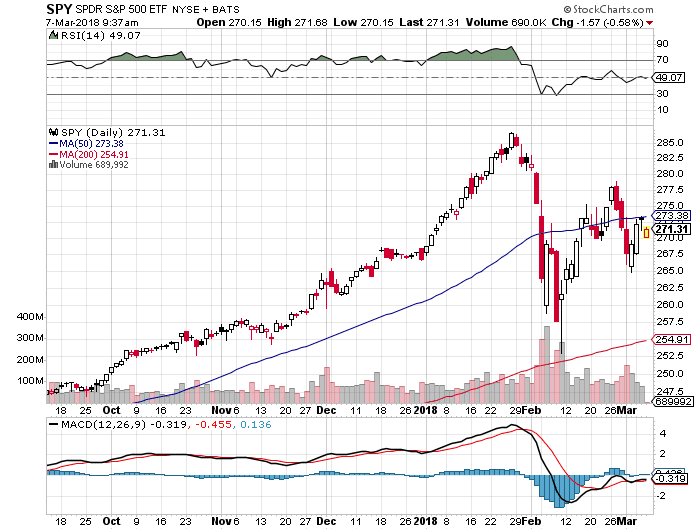

## Lets Create Technical indicators using our dataset

In [8]:
instrument = 'EUR_USD'
data = pd.read_csv('dataset/EUR_USD.csv', index_col=['time_EUR_USD'])

### For this task I am using pandas_ta which provide over 80 diffrent technical indicators 

In [9]:
import pandas_ta as ta

# if we look what they provide using dir we can see they have the most comming technical indicators
# in the industry 

print(dir(ta))

['AnalysisIndicators', 'BasePandasObject', 'DistributionNotFound', 'MINUTES_IN_HOUR', 'PandasObject', 'TRADING_DAYS_IN_YEAR', 'TRADING_HOURS_IN_DAY', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_dist', 'accbands', 'ad', 'adosc', 'adx', 'amat', 'ao', 'aobv', 'apo', 'aroon', 'atr', 'bbands', 'bop', 'cci', 'cg', 'cmf', 'cmo', 'combination', 'coppock', 'core', 'cross', 'decreasing', 'dema', 'df_error_analysis', 'dist_loc', 'donchian', 'dpo', 'efi', 'ema', 'eom', 'fibonacci', 'fisher', 'fwma', 'get_distribution', 'get_drift', 'get_offset', 'here', 'hl2', 'hlc3', 'hma', 'ichimoku', 'increasing', 'kama', 'kc', 'kst', 'kurtosis', 'linear_decay', 'linreg', 'log_return', 'long_run', 'macd', 'mad', 'massi', 'math', 'median', 'mfi', 'midpoint', 'midprice', 'mom', 'momentum', 'mul', 'name', 'natr', 'np', 'nvi', 'obv', 'ohlc4', 'os', 'overlap', 'pascals_triangle', 'pd', 'percent_return', 'performance', 'ppo', '

## This fucntion performce technical analyze on our dataset

In [10]:
def ta_data(close, high, low, _open, volume, name, data):

    data[["Histogram", "MACD", "Signal"]] = ta.macd(close)        # MACD
    data['SMA_10'] = ta.sma(close)                                # SMA 10
    data['SMA_25'] = ta.sma(close, length=25)                     # SMA 25
    data['SMA_50'] = ta.sma(close, length=50)                     # SMA 50
    data['SMA_100'] = ta.sma(close, length=100)                   # SMA 100
    data['SMA_150'] = ta.sma(close, length=150)                   # SMA 150
    data['SMA_200'] = ta.sma(close, length=200)                   # SMA 200
    data['RSI'] = ta.rsi(close)                                   # RSI
    data[['ACCE_H', "ACCE_L", "ACCE_C"]] = ta.accbands(high, low, close, length=20)  # Acceleration Badns
    data['AD'] = ta.ad(high, low, close, volume)                              # AD
    data['ADOSC'] = ta.adosc(high, low, close, volume)                        # Accumulation/Distribution Oscillator or chaikin oscillator
    data[['AMAT_LR_2', 'AMAT_SR_2']] = ta.amat(close)                         # Archer Moving Averages Trends (AMAT)
    data['AO'] = ta.ao(high, low)                                             # Awesome Oscillator (AO)
    data[['OBV','OBV_min_2', 'OBV_max_2','OBV_EMA_2','OBV_EMA_4', 'AOBV_LR_2', 'AOBV_SR_2']] = ta.aobv(close, volume) # Archer On Balance Volume (AOBV)
    data['APO'] = ta.apo(close)                                               # Absolute Price Oscillator (APO)
    data[['AROOND_14', 'AROONU_14']] =  ta.aroon(close, length=14)            # AROON
    data[['BBL_20', 'BBM_20', 'BBU_20']] = ta.bbands(close)                   # Bollinger Bands (BBANDS)
    data['BOP'] = ta.bop(_open, high, low, close)                              # Balance of power (BOP)
    data['CCI'] = ta.cci(high, low, close)                                    # Commodity Channel index (CCI)
    data['CG'] = ta.cg(close)                                                 # Center of Gravity (CG)
    data['CMF_20'] = ta.cmf(high, low, close, volume)                         # Chaikin Money Flow (CMF)
    data['CMO_9'] = ta.cmo(close, length=9)                                   # Chande Momentum Oscillator (CMO)
    data['COPPOCK'] = ta.coppock(close)                                       # Coppock Curve (COPC)
    data['DEMA_9'] = ta.dema(close, length=9)                                 # Double EMA (DEMA)
    data[['DCL_10_20', 'DCM_10_20', 'DCU_10_20']] = ta.donchian(close)        # Donchain Channels  (DC)
    data['DPO_21'] = ta.dpo(close, length=21, centered=False)                 # Detrend Price Oscillator (DPO)
    data['EFI_13'] = ta.efi(close, volume, length=13)                         # Elder's Force Index (EPI)
    data['EMA_12'] = ta.ema(close, length=12)                                 # EMA 12
    data['EMA_26'] = ta.ema(close, length=26)                                 # EMA 26
    data['EMA_50'] = ta.ema(close, length=50)                                 # EMA 50
    data['EMA_200'] = ta.ema(close, length=200)                               # EMA 200
    data['EOM_14'] = ta.eom(high, low, close, volume)                         # Ease of Momement (EOM)
    data['FWMA_14'] = ta.fwma(close, length=14)                               # Fibonacci's Weighted Moving Average (FWMA)
    data['HMA_9'] = ta.hma(close, length=9)                                   # Hull Moving Average (HMV)
    data[['KCL_20', 'KCB_20', 'KCU_20']] = ta.kc(high, low, close, scalar=1)  # Keltner Channels (KC)
    data[['KST_10_15_20_30_10_10_10_15', 'KSTS_9']] = ta.kst(close)           # Know Sure Thing (KST)
    data['Kurtosis'] = ta.kurtosis(close, length=21)                          # Kurtosis 
    data['linreg'] = ta.linreg(close, length=100)                             # Linear Regression Moving Average (linreg)
    data['linreg_cor'] = ta.linreg(close, length=100, r=True)                 # linear regression Correlation
    data['linreg_int'] = ta.linreg(close, length=100, intercept=True)         # linear regression Intercept 
    data['linreg_deg'] = ta.linreg(close, length=100, degrees=True)           # linear regression Degrees 
    data['linreg_ang'] = ta.linreg(close, length=100, angle=True)             # linear regression Angle
    data['linreg_slope'] = ta.linreg(close, length=100, slope=True)           # linear regression Slope
    data['linreg_tsf'] = ta.linreg(close, length=100, tsf=True)               # linear regression Forecast Value
    data['log_return'] = ta.log_return(close)                                 # log return 
    data['MI'] = ta.massi(high, low, slow=9)                                  # Mass Index
    data['median'] = ta.median(close, length=20)                              # median 
    data['MOM'] = ta.mom(close, length=10)                                    # Momentum (MOM)
    data['OBV'] = ta.obv(close, volume)                                       # On Balance Volume (OBV)
    data['NVI'] = ta.nvi(close, volume)                                       # Negative Volume Index (NVI)
    data['PVI'] = ta.pvi(close, volume)                                       # Positive Volume Index (PVI)
    data['PVT'] = ta.pvt(close, volume)                                       # Price Volume Trend (PVT)
    data['Qstick'] = ta.qstick(_open, close, length=14)                        # Q Stick 
    data['ROC'] = ta.roc(close, length=9)                                     # Rate of Change (ROC)
    data[['RVI_10_4', 'RVIS_10_4']] = ta.rvi(_open, high, low, close, length=10)  # Raltive Viger Index (RVI)
    data['skew'] = ta.skew(close, length=21)                                     # skewness
    data['stdev'] = ta.stdev(close, length=20)                                   # Standard Deivation 
    data[['STOCHF_3', 'STOCH_14', 'STOCH_3']] = ta.stoch(high, low, close, slow_k=14, fast_k=3) # Stochastic (STOCH)
    data['T3'] = ta.t3(close, length=8)                                          # Tim Tillson's Moving Average (T3)
    data['TEMA'] = ta.tema(close, length=9)                                    # Triple Exponential Moving Average (TEMA)
    data['TRIX'] = ta.trix(close)                                              # Trix (TRIX)
    data['TSI'] = ta.tsi(close)                                                # True Strength Index (TSI)
    data['UO'] = ta.uo(high, low, close)                                       # Ultimate Oscillator (UO)
    data['VWAP'] = ta.vwap(high, low, close, volume)                           # Volume Weighted Average Price (VWAP)
    data['VWMA'] = ta.vwma(close, volume, length=20)                           # Volume Weighted Moving Average (VWMA)
    data['WILLR'] = ta.willr(high, low, close, length=14)                      # William's Percent R (WILLR)
    
    data = pd.concat([data], axis=1)
    data.to_csv(name)

## Lets run our function and plot our data with technical indicators 

In [11]:
high = data[f'high_{instrument}']
low = data[f'low_{instrument}']
close = data[f'close_{instrument}']
volume = data[f'Volume_{instrument}']
_open = data[f'open_{instrument}']
# time = data[f'time_{instrument}']
name = f'dataset/ta_{instrument}.csv'

ta_data(close=close, high=high, low=low, _open=_open, volume=volume, name=name, data=data)

## After running our function lets see the result

In [12]:
data = pd.read_csv('dataset/ta_EUR_USD.csv', parse_dates=['time_EUR_USD'])

data.head()

time_EUR_USD  close_EUR_USD  open_EUR_USD  high_EUR_USD  \
0 2010-01-03 14:00:00+00:00        1.43172       1.43120       1.43172   
1 2010-01-03 18:00:00+00:00        1.43036       1.43172       1.43425   
2 2010-01-03 22:00:00+00:00        1.42714       1.43030       1.43358   
3 2010-01-04 02:00:00+00:00        1.43012       1.42712       1.43089   
4 2010-01-04 06:00:00+00:00        1.43948       1.43010       1.43964   

   low_EUR_USD  Volume_EUR_USD  Histogram  MACD  Signal  SMA_10  ...  \
0      1.43120               3        NaN   NaN     NaN     NaN  ...   
1      1.42926            1024        NaN   NaN     NaN     NaN  ...   
2      1.42576            5994        NaN   NaN     NaN     NaN  ...   
3      1.42708            2836        NaN   NaN     NaN     NaN  ...   
4      1.42694            9020        NaN   NaN     NaN     NaN  ...   

   STOCH_14  STOCH_3  T3  TEMA  TRIX  TSI  UO      VWAP  VWMA  WILLR  
0       NaN      NaN NaN   NaN   NaN  NaN NaN  1.431547   NaN    NaN  
1       NaN      NaN NaN   NaN   NaN  NaN NaN  1.431291   NaN    NaN  
2       NaN      NaN NaN   NaN   NaN  NaN NaN  1.429187   NaN    NaN  
3       NaN      NaN NaN   NaN   NaN  NaN NaN  1.429238   NaN    NaN  
4       NaN      NaN NaN   NaN   NaN  NaN NaN  1.432160   NaN    NaN  

[5 rows x 93 columns]

# Data exploration

I have ploted every features and that because in the financial world each of these indecator matter for making a decision for when to buy (going long) or when to sell (going short). 

In [13]:
n = 100                       # number of candles to show
time = data['time_EUR_USD'].tail(n)   # time to show 
plt.style.use('seaborn')

## # Simple Moving Avarages 10, 25, 50, 100, 150, 200

Simple Moving Average (SMA)

The Simple Moving Average is the classic moving average that is the equally
weighted average over n periods.

Sources:
    https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/

/Users/hasanin24/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


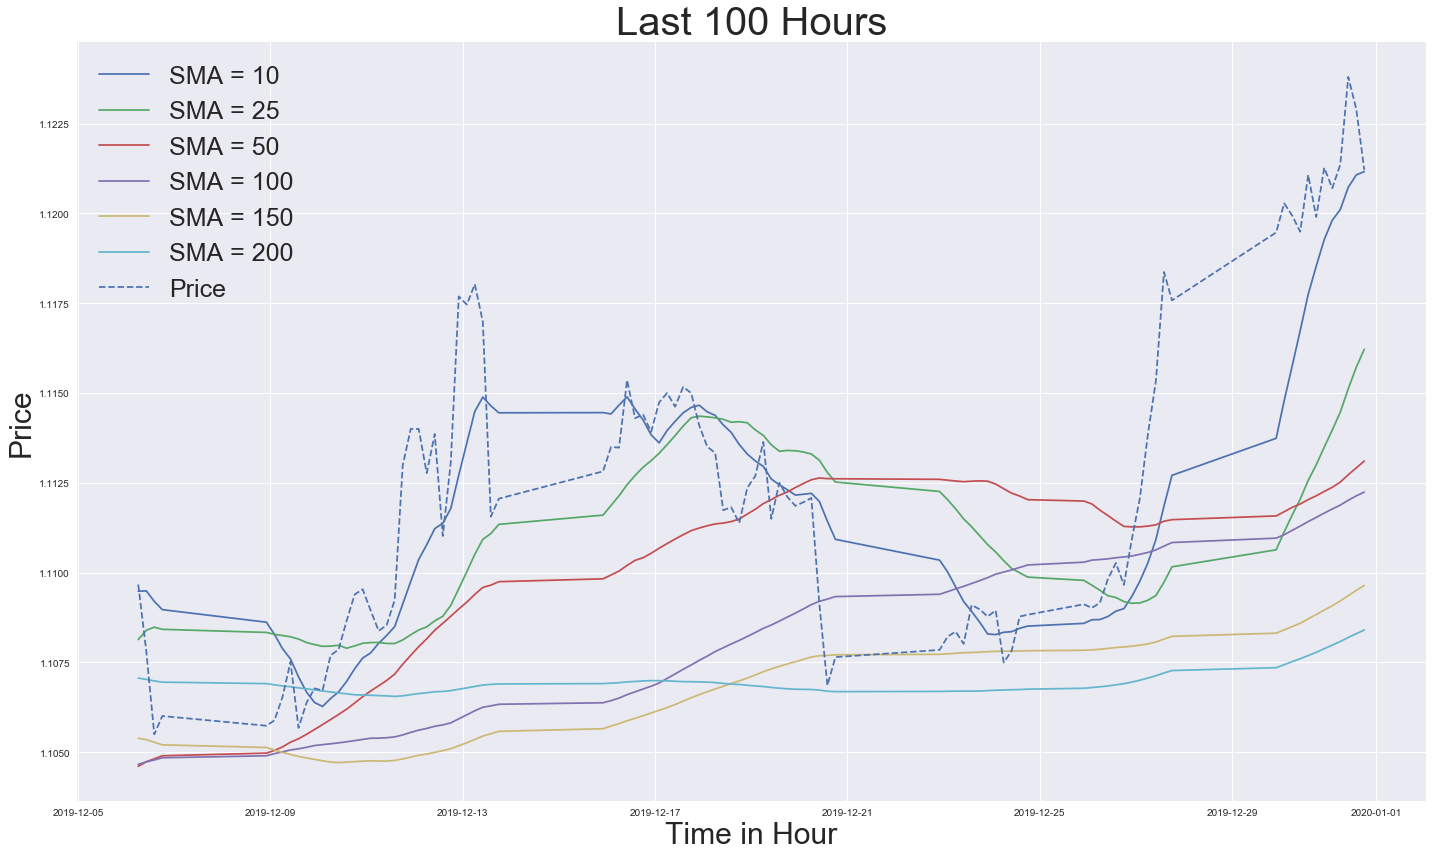

In [14]:
plt.figure(figsize=(20,12))
plt.plot_date(time, data['SMA_10'].tail(n), linestyle="solid", marker=None, label="SMA = 10")
plt.plot_date(time, data['SMA_25'].tail(n), linestyle="solid", marker=None, label="SMA = 25")
plt.plot_date(time, data['SMA_50'].tail(n), linestyle="solid", marker=None, label="SMA = 50")
plt.plot_date(time, data['SMA_100'].tail(n), linestyle="solid", marker=None, label="SMA = 100")
plt.plot_date(time, data['SMA_150'].tail(n), linestyle="solid", marker=None, label="SMA = 150")
plt.plot_date(time, data['SMA_200'].tail(n), linestyle="solid", marker=None, label="SMA = 200")
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.xlabel('Time in Hour', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.title(f"Last {n} Hours", fontsize=40)
plt.legend(fontsize=25)
plt.tight_layout()
plt.show()

# MACD

Moving Average Convergence Divergence (MACD)

The MACD is a popular indicator to that is used to identify a security's trend.
While APO and MACD are the same calculation, MACD also returns two more series
called Signal and Histogram.  The Signal is an EMA of MACD and the Histogram is
the difference of MACD and Signal.

Sources:
    https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)

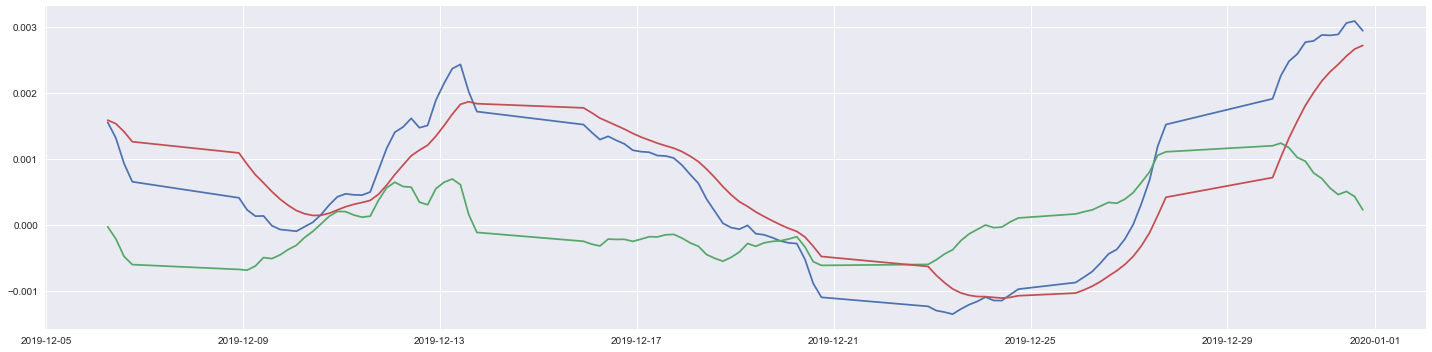

In [15]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["Histogram"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["MACD"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["Signal"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# RSI

Relative Strength Index (RSI)

The Relative Strength Index is popular momentum oscillator used to measure the velocity as well as the magnitude of directional price movements.

Sources: https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)

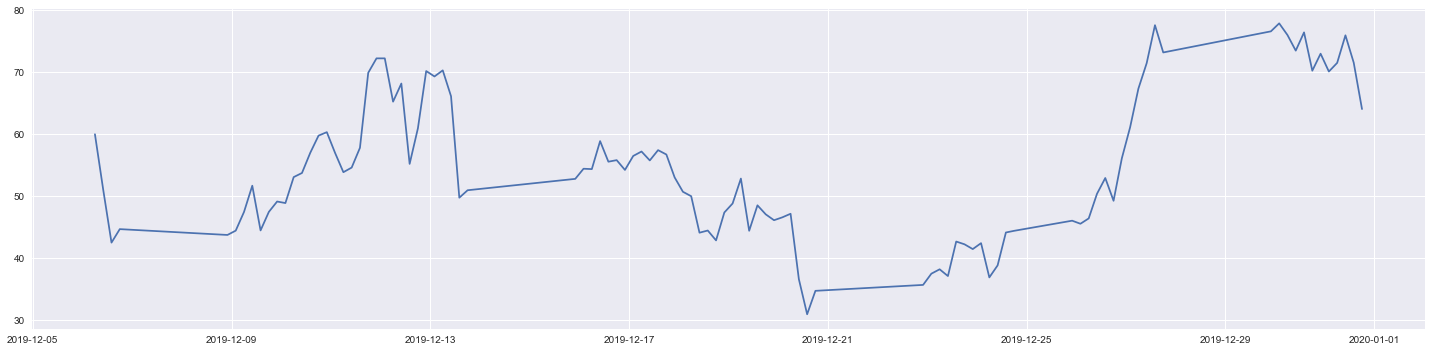

In [16]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["RSI"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Accelaration Bonds


Average True Range (ATR)

Averge True Range is used to measure volatility, especially volatility caused by gaps or limit moves.

Sources: https://www.tradingview.com/wiki/Average_True_Range_(ATR)

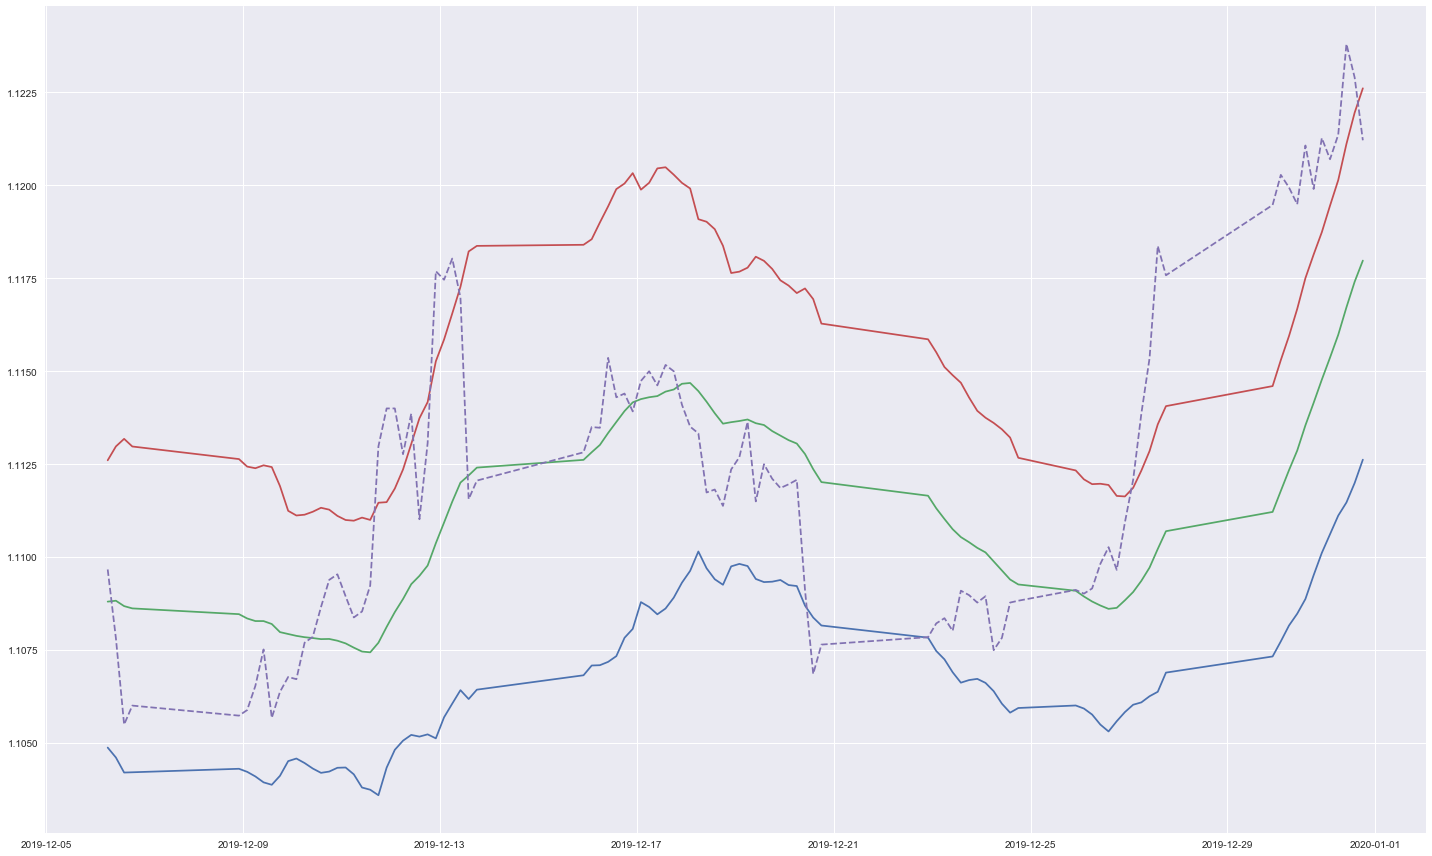

In [17]:
plt.figure(figsize=(20,12))
plt.plot_date(time, data["ACCE_H"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["ACCE_L"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["ACCE_C"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Accumulation/Distribution (AD)

Accumulation/Distribution (AD)

Accumulation/Distribution indicator utilizes the relative position of the close to it's High-Low range with volume. Then it is cumulated.

Sources: https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/accumulationdistribution-ad/

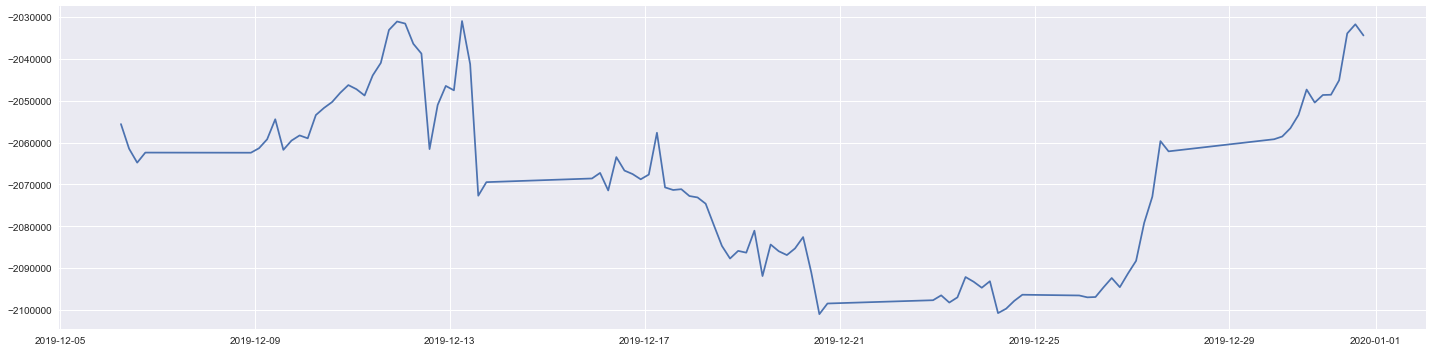

In [18]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["AD"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Accumulation/Distribution Oscillator or chaikin oscillator

Accumulation/Distribution Oscillator or Chaikin Oscillator

Accumulation/Distribution Oscillator indicator utilizes Accumulation/Distribution and treats it similarily to MACD or APO.

Sources: https://www.investopedia.com/articles/active-trading/031914/understanding-chaikin-oscillator.asp

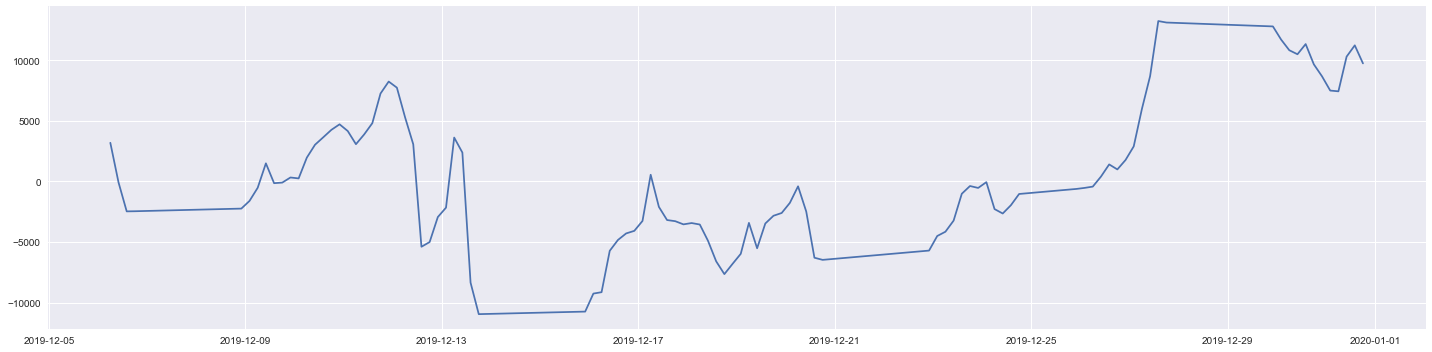

In [19]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["ADOSC"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Awesome Oscillator (AO)

Awesome Oscillator (AO)

The Awesome Oscillator is an indicator used to measure a security's momentum. AO is generally used to affirm trends or to anticipate possible reversals.

Sources: https://www.tradingview.com/wiki/Awesome_Oscillator_(AO) https://www.ifcm.co.uk/ntx-indicators/awesome-oscillator

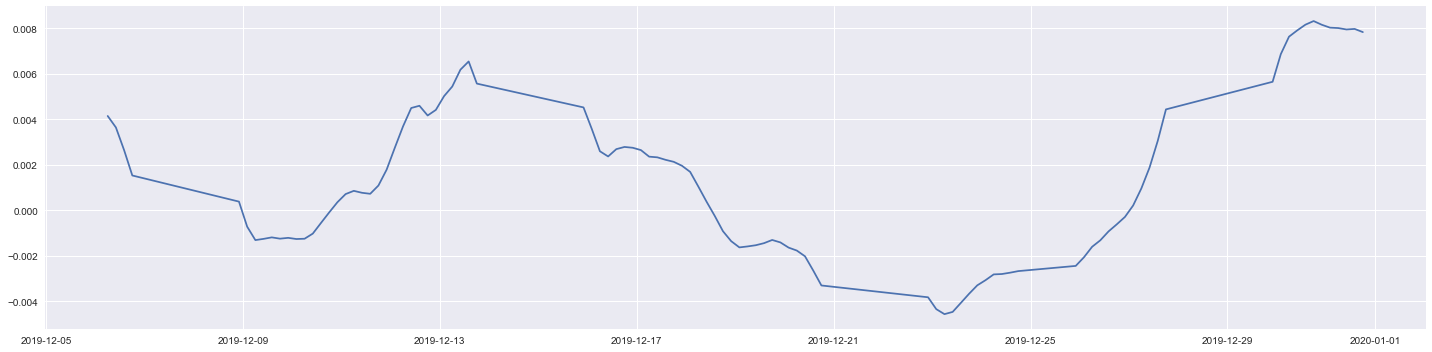

In [20]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["AO"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Archer On Balance Volume (AOBV)

Indicator: Archer On Balance Volume (AOBV)

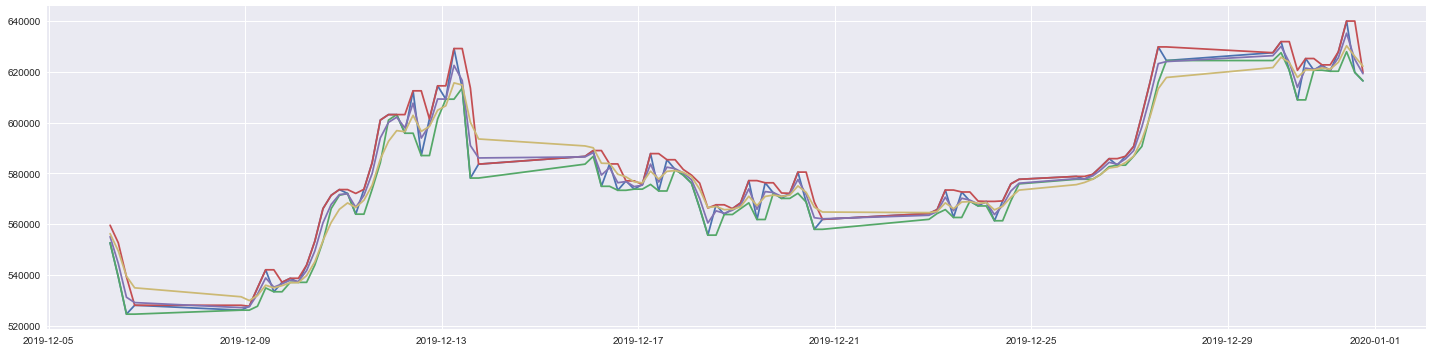

In [21]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["OBV"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["OBV_min_2"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["OBV_max_2"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["OBV_EMA_2"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["OBV_EMA_4"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Absolute Price Oscillator (APO)

Absolute Price Oscillator (APO)

The Absolute Price Oscillator is an indicator used to measure a security's momentum. It is simply the difference of two Exponential Moving Averages (EMA) of two different periods. Note: APO and MACD lines are equivalent.

Sources: https://www.investopedia.com/terms/p/ppo.asp

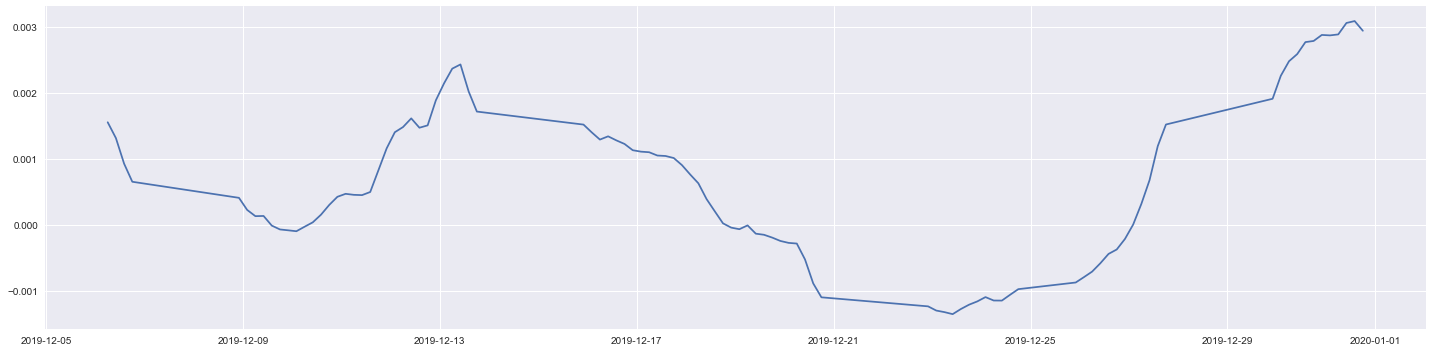

In [22]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["APO"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Aroon

Aroon (AROON)

Aroon attempts to identify if a security is trending and how strong.

Sources: https://www.tradingview.com/wiki/Aroon https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/aroon-ar/

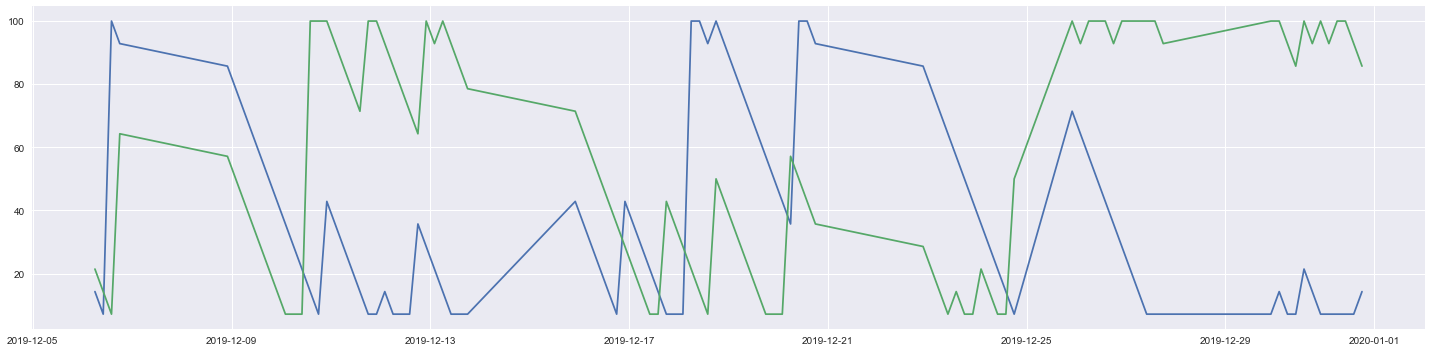

In [23]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["AROOND_14"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["AROONU_14"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Bollinger Bands

Bollinger Bands (BBANDS)

A popular volatility indicator.

Sources: https://www.tradingview.com/wiki/Bollinger_Bands_(BB)

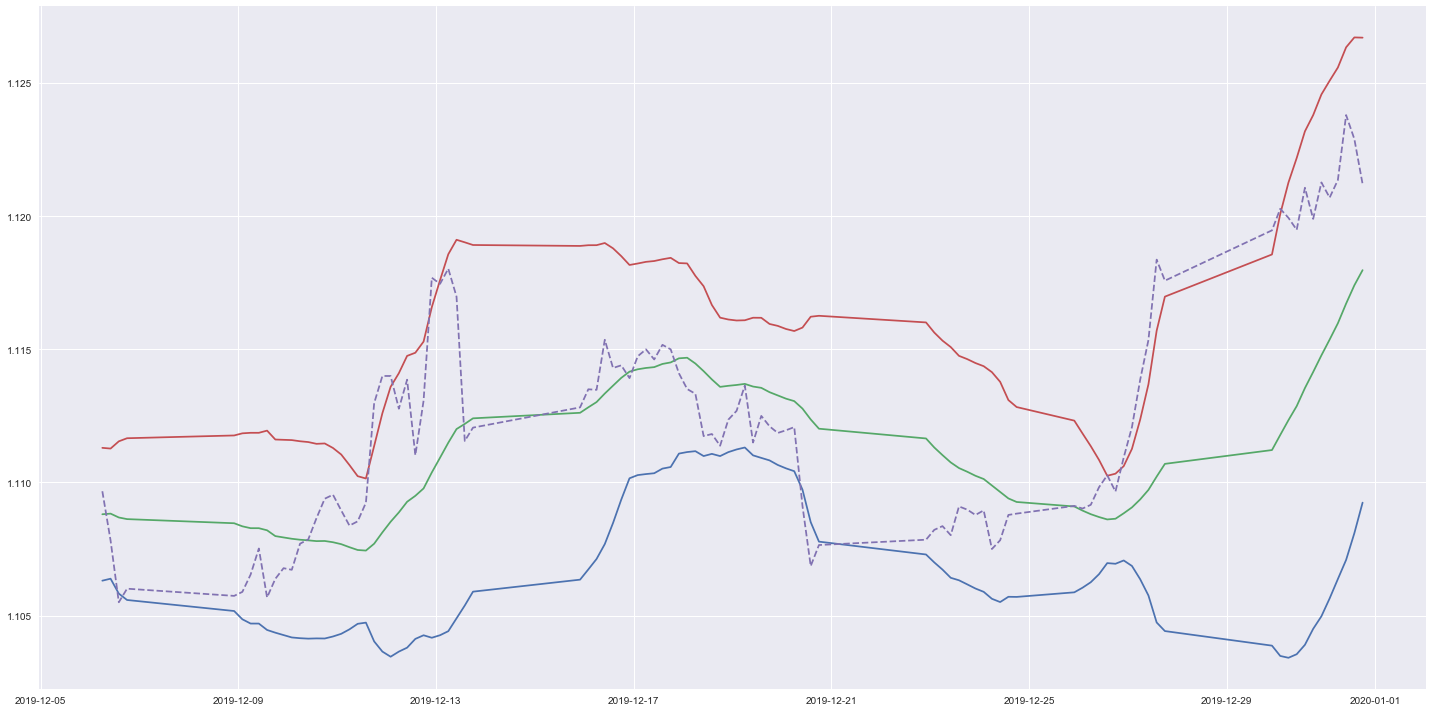

In [24]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["BBL_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["BBM_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["BBU_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Balance of Power (BOP)

Balance of Power (BOP)

Balance of Power measure the market strength of buyers against sellers.

Sources: http://www.worden.com/TeleChartHelp/Content/Indicators/Balance_of_Power.htm

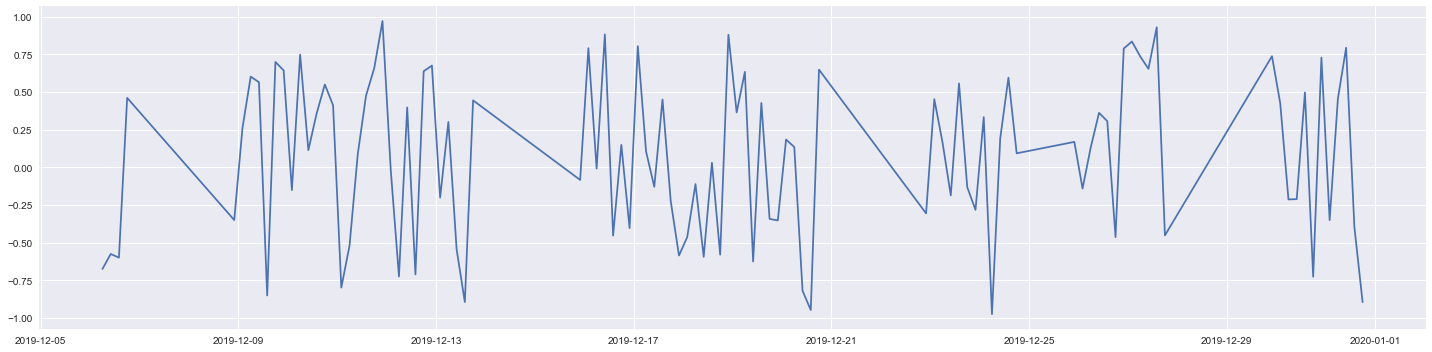

In [25]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["BOP"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Commodity Channel index (CCI)

Commodity Channel Index (CCI)

Commodity Channel Index is a momentum oscillator used to primarily identify overbought and oversold levels relative to a mean.

Sources: https://www.tradingview.com/wiki/Commodity_Channel_Index_(CCI)

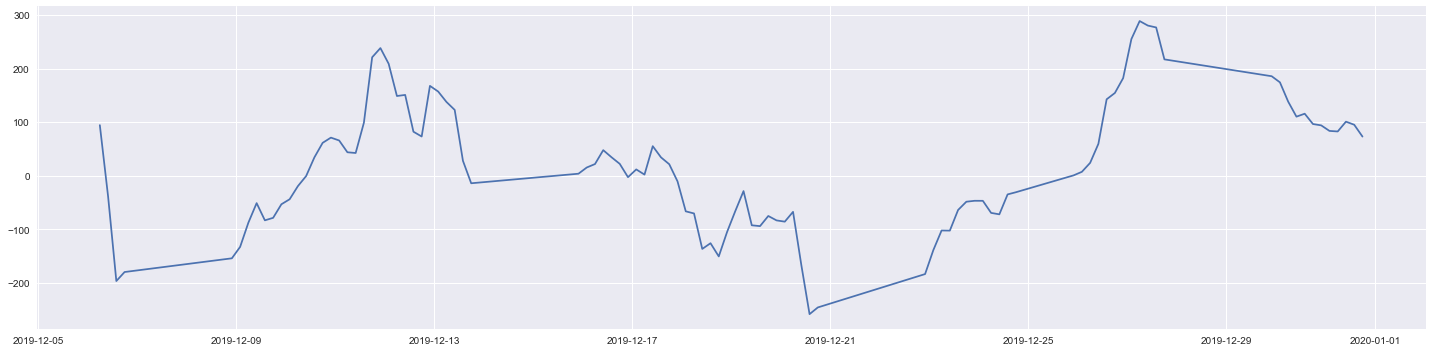

In [26]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["CCI"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Center of Gravity 

Center of Gravity (CG)

The Center of Gravity Indicator by John Ehlers attempts to identify turning points while exhibiting zero lag and smoothing.

Sources: http://www.mesasoftware.com/papers/TheCGOscillator.pdf

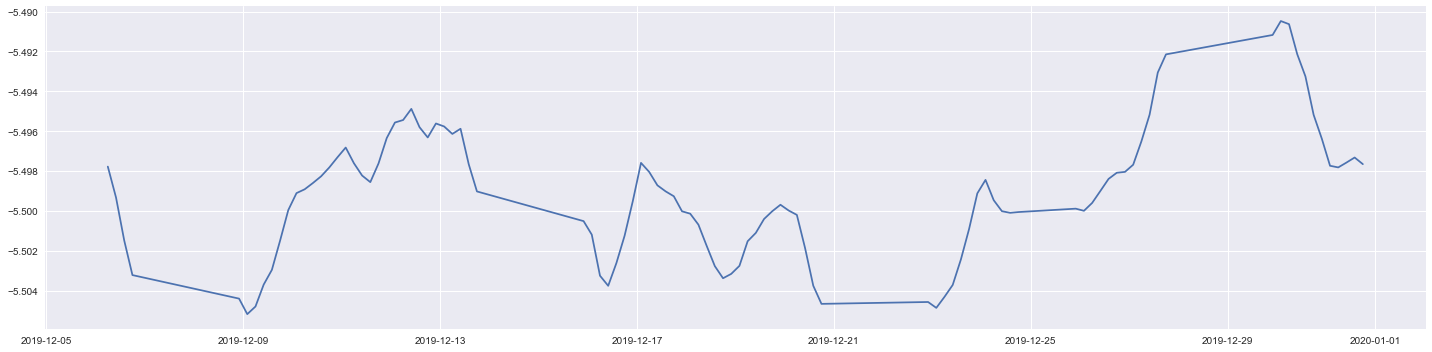

In [27]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["CG"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Chiking Money Flow (CMF)

Chaikin Money Flow (CMF)

Chailin Money Flow measures the amount of money flow volume over a specific period in conjunction with Accumulation/Distribution.

Sources: https://www.tradingview.com/wiki/Chaikin_Money_Flow_(CMF) https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:chaikin_money_flow_cmf

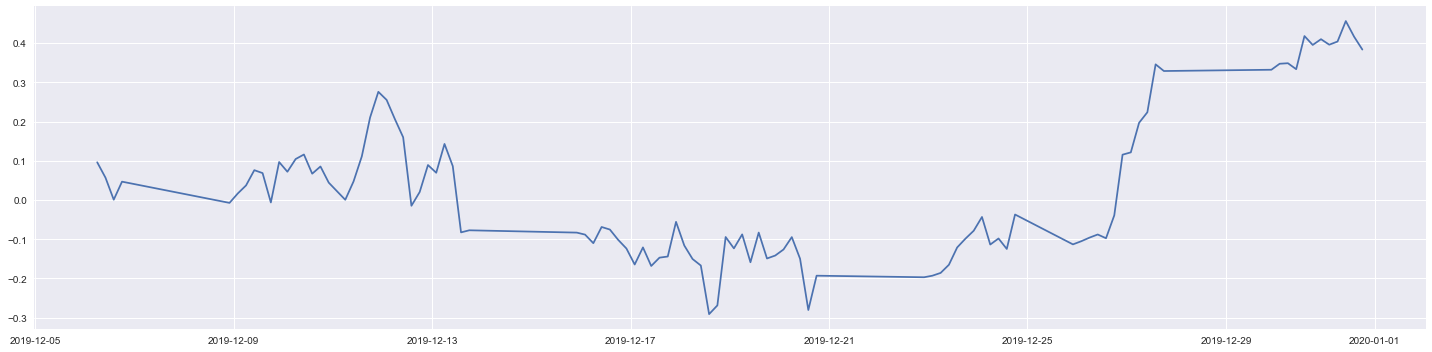

In [28]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["CMF_20"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Chande Momentum Oscillator (CMO)

Chande Momentum Oscillator (CMO)

Attempts to capture the momentum of an asset with overbought at 50 and oversold at -50.

Sources: https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/chande-momentum-oscillator-cmo/

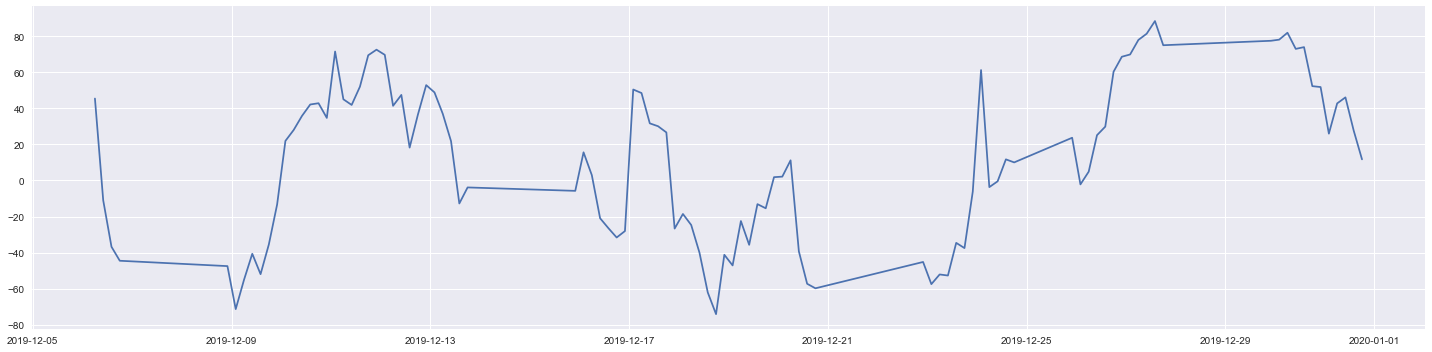

In [29]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["CMO_9"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Coppock Curve (COPC)

Coppock Curve (COPC)

Coppock Curve (originally called the "Trendex Model") is a momentum indicator is designed for use on a monthly time scale. Although designed for monthly use, a daily calculation over the same period can be made, converting the periods to 294-day and 231-day rate of changes, and a 210-day weighted moving average.

Sources: https://en.wikipedia.org/wiki/Coppock_curve

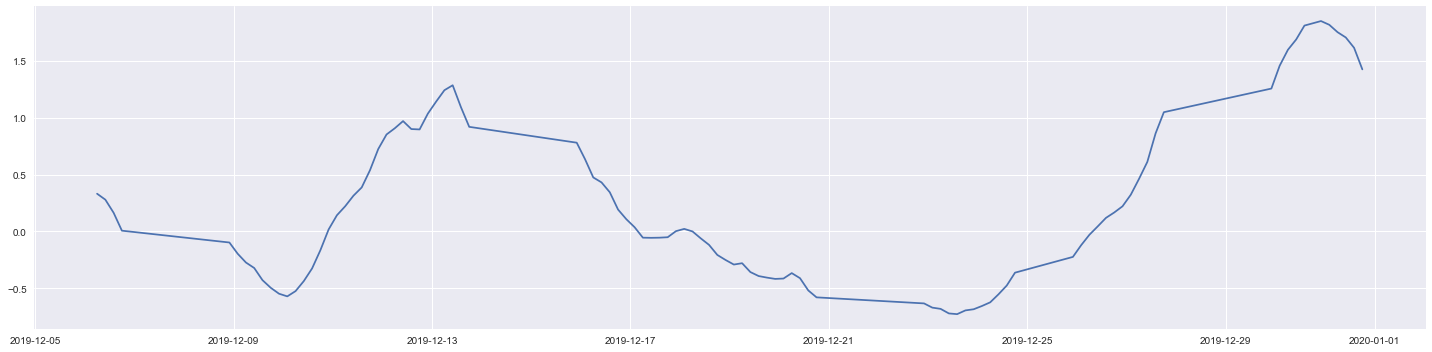

In [30]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["COPPOCK"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Double Exponential Moving Average (DEMA)

Coppock Curve (COPC)

Coppock Curve (originally called the "Trendex Model") is a momentum indicator is designed for use on a monthly time scale. Although designed for monthly use, a daily calculation over the same period can be made, converting the periods to 294-day and 231-day rate of changes, and a 210-day weighted moving average.

Sources: https://en.wikipedia.org/wiki/Coppock_curve

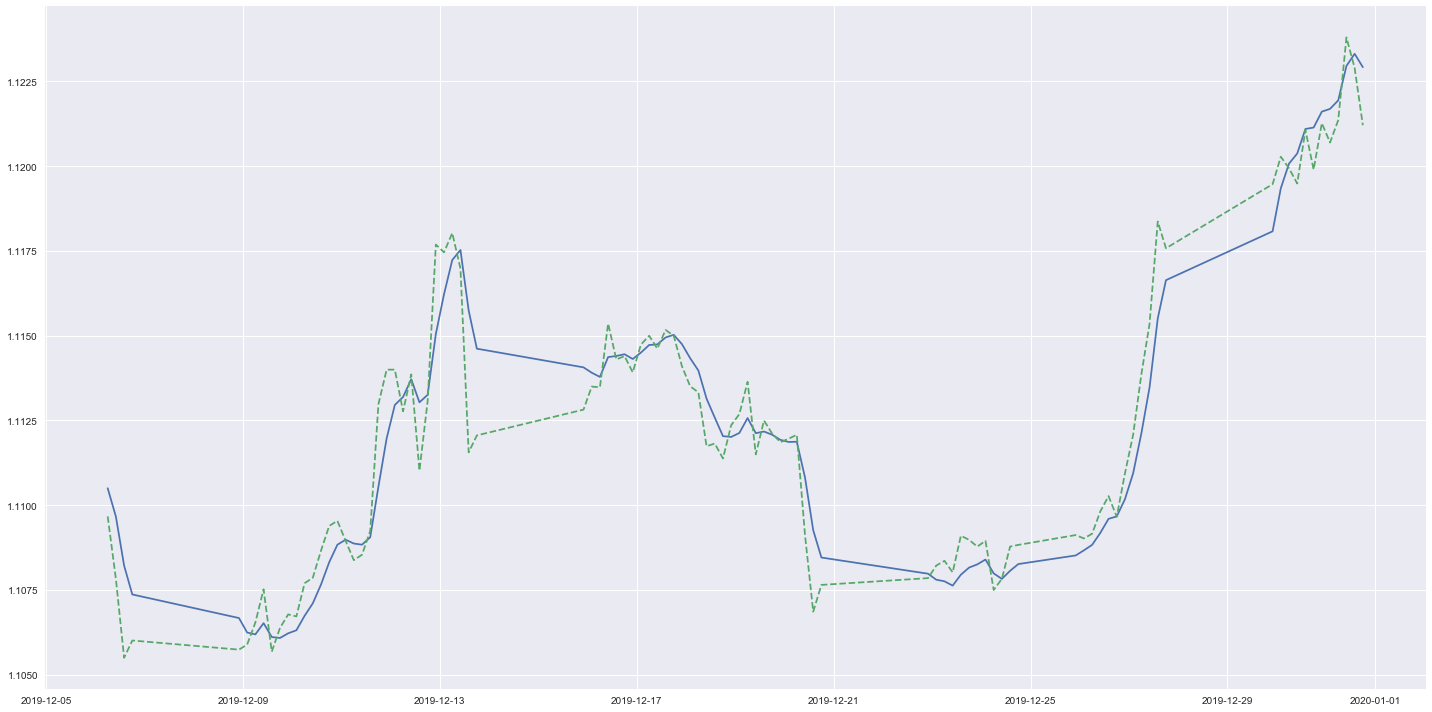

In [31]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["DEMA_9"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Donchian Channels (DC)

Donchian Channels (DC)

Donchian Channels are used to measure volatility, similar to Bollinger Bands and Keltner Channels.

Sources: https://www.tradingview.com/wiki/Donchian_Channels_(DC)

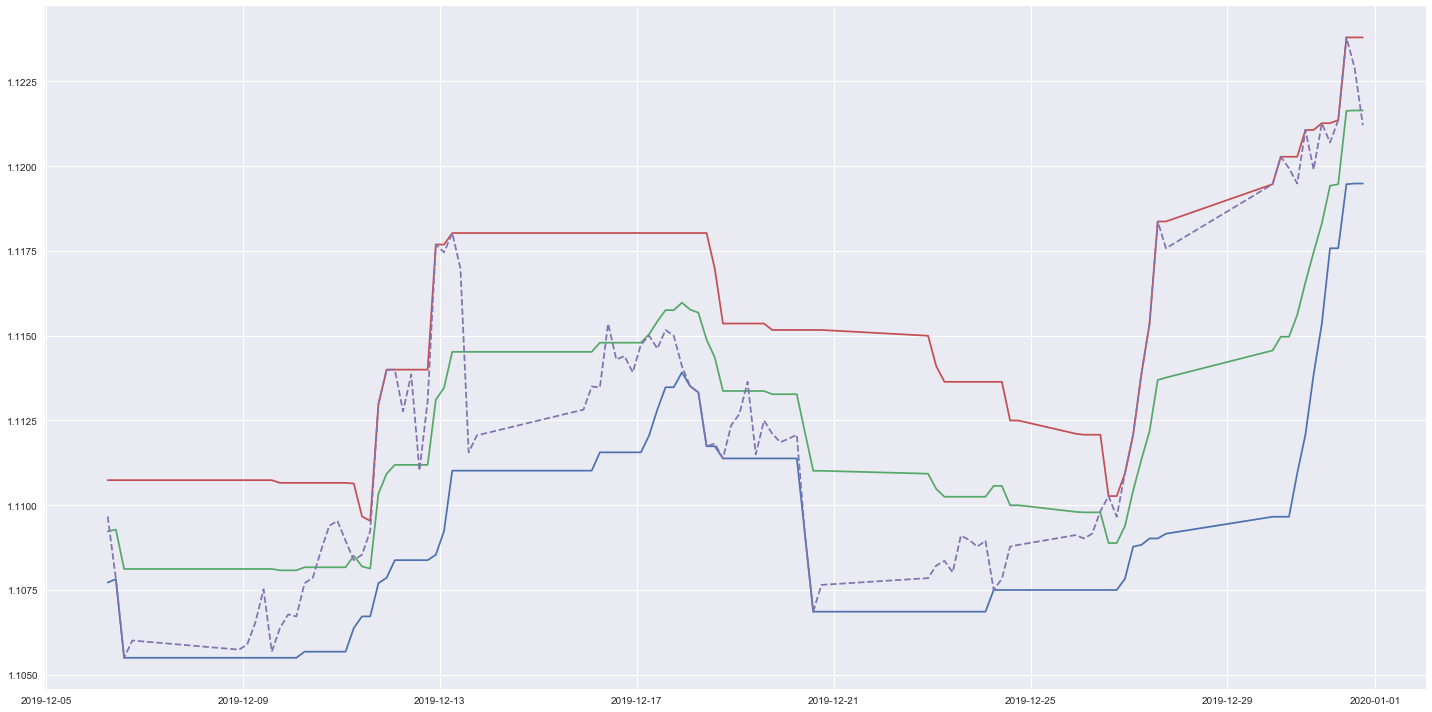

In [32]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["DCL_10_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["DCM_10_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["DCU_10_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Elder's Force Index (EFI)

Elder's Force Index (EFI)

Elder's Force Index measures the power behind a price movement using price and volume as well as potential reversals and price corrections.

Sources: https://www.tradingview.com/wiki/Elder%27s_Force_Index_(EFI) https://www.motivewave.com/studies/elders_force_index.htm

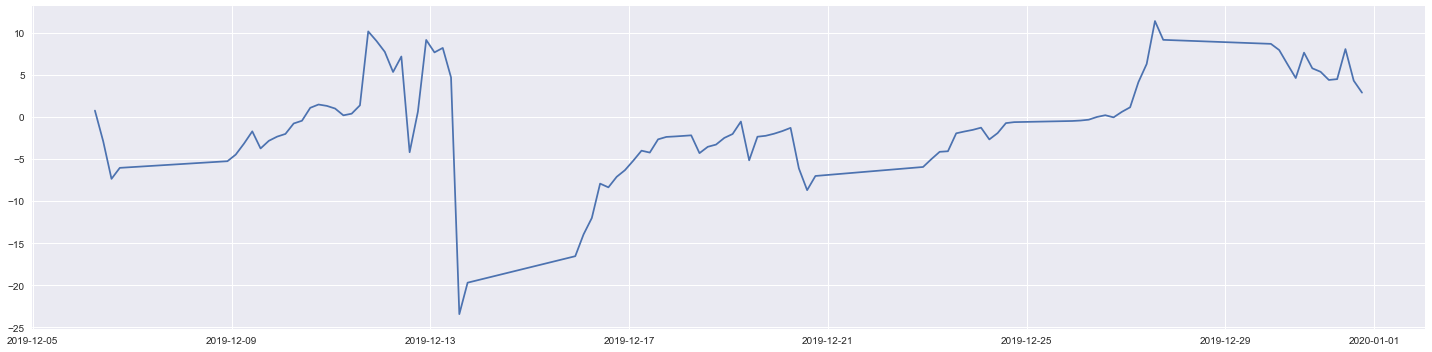

In [33]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["EFI_13"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Exponetial Moving Average (EMA)

Exponential Moving Average (EMA)

The Exponential Moving Average is more responsive moving average compared to the Simple Moving Average (SMA). The weights are determined by alpha which is proportional to it's length. There are several different methods of calculating EMA. One method uses just the standard definition of EMA and another uses the SMA to generate the initial value for the rest of the calculation.

Sources: https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_averages https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp

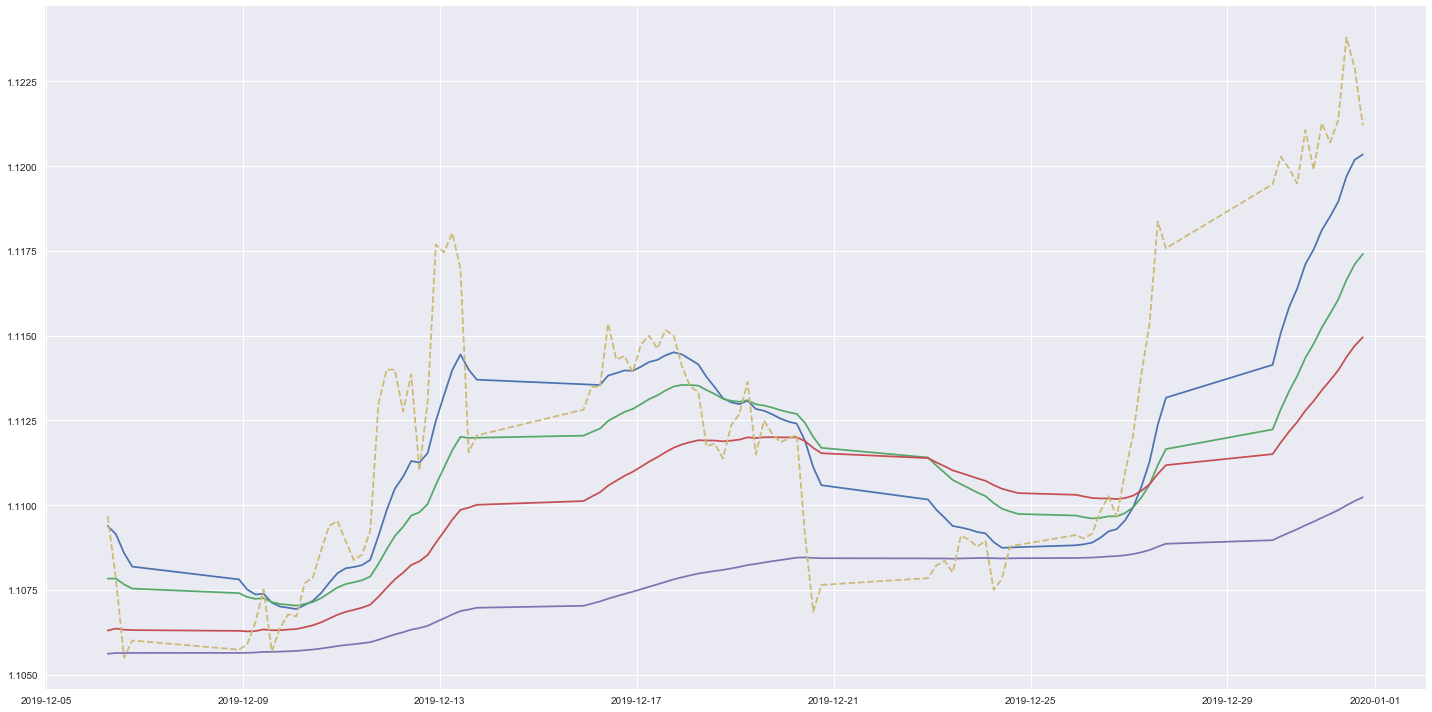

In [34]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["EMA_12"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["EMA_26"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["EMA_50"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["EMA_200"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Ease of Movment (EOM)

Ease of Movement (EOM)

Ease of Movement is a volume based oscillator that is designed to measure the relationship between price and volume flucuating across a zero line.

Sources: https://www.tradingview.com/wiki/Ease_of_Movement_(EOM) https://www.motivewave.com/studies/ease_of_movement.htm https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:ease_of_movement_emv

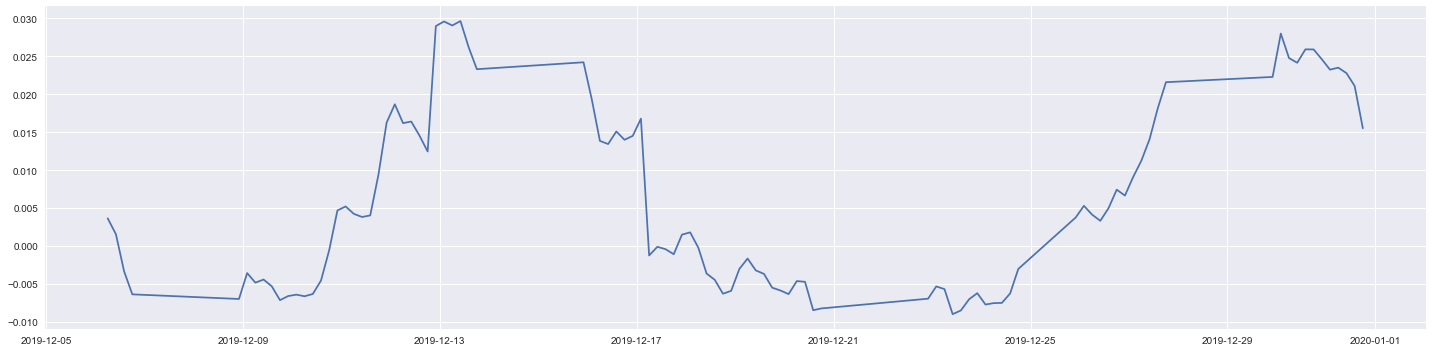

In [35]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["EOM_14"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Fibonacci's Weighted Moving Average (FWMA)

Ease of Movement (EOM)

Ease of Movement is a volume based oscillator that is designed to measure the relationship between price and volume flucuating across a zero line.

Sources: https://www.tradingview.com/wiki/Ease_of_Movement_(EOM) https://www.motivewave.com/studies/ease_of_movement.htm https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:ease_of_movement_emv

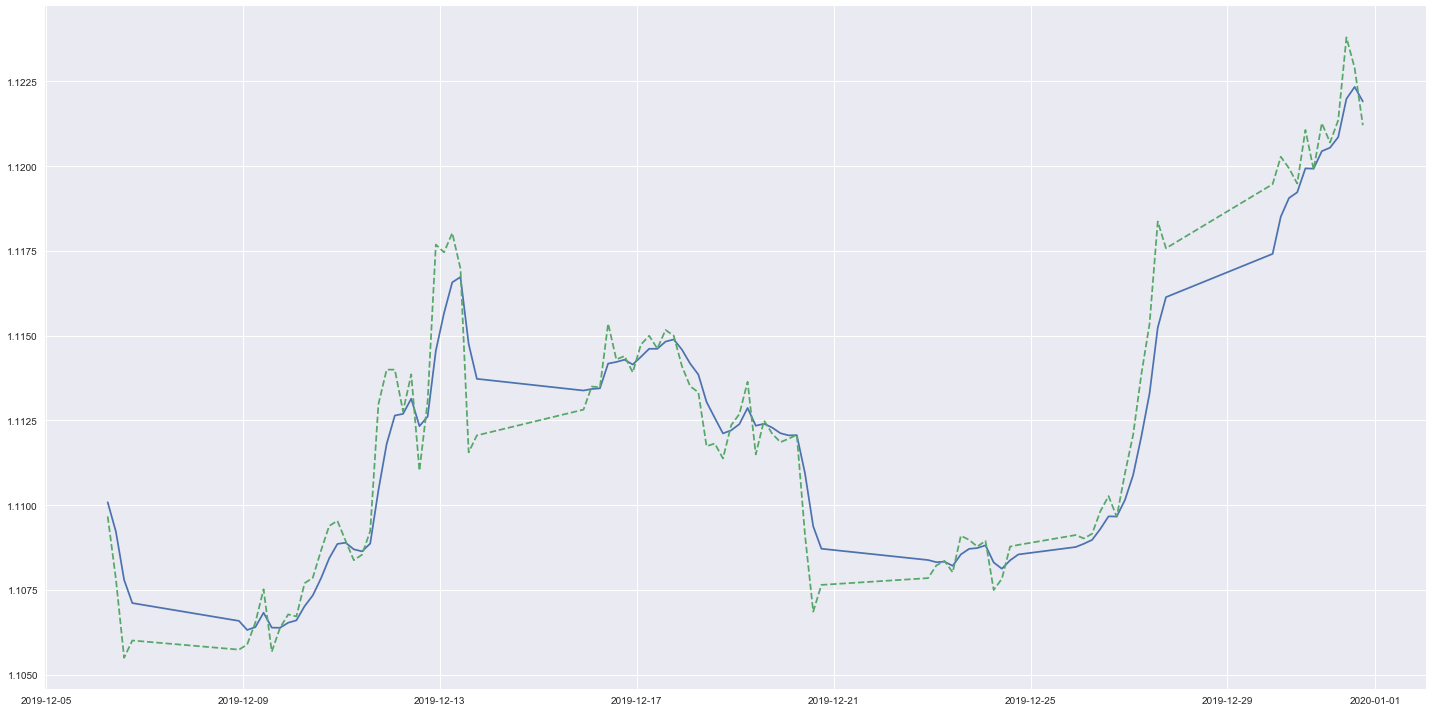

In [36]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["FWMA_14"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Hull Moving Average (HMA)

Hull Moving Average (HMA)

The Hull Exponential Moving Average attempts to reduce or remove lag in moving averages.

Sources: https://alanhull.com/hull-moving-average

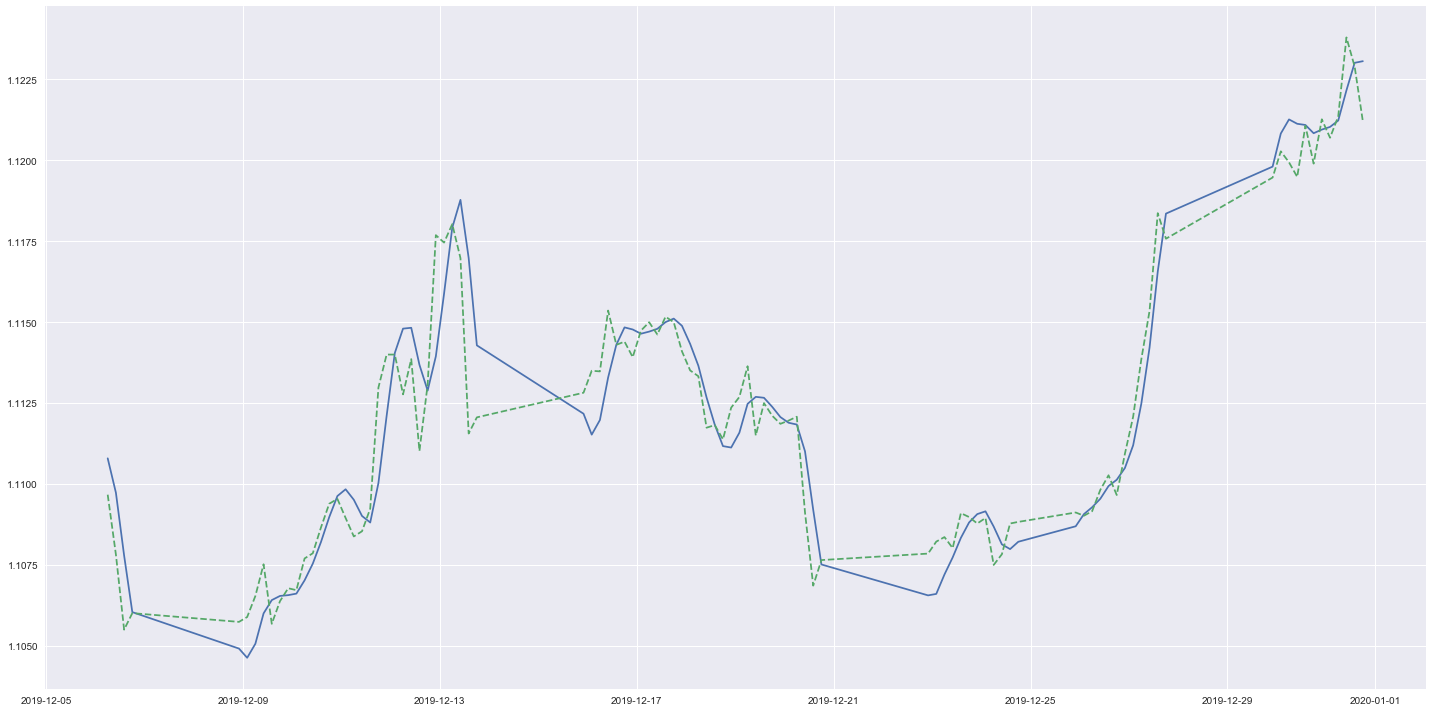

In [37]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["HMA_9"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Kaufman's Adaptive Moving Average (KAMA)

plt.figure(figsize=(20,10))
plt.plot_date(time, data["KAMA_21"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Keltner channels (KC)

Keltner Channels (KC)

A popular volatility indicator similar to Bollinger Bands and Donchian Channels.

Sources: https://www.tradingview.com/wiki/Keltner_Channels_(KC)

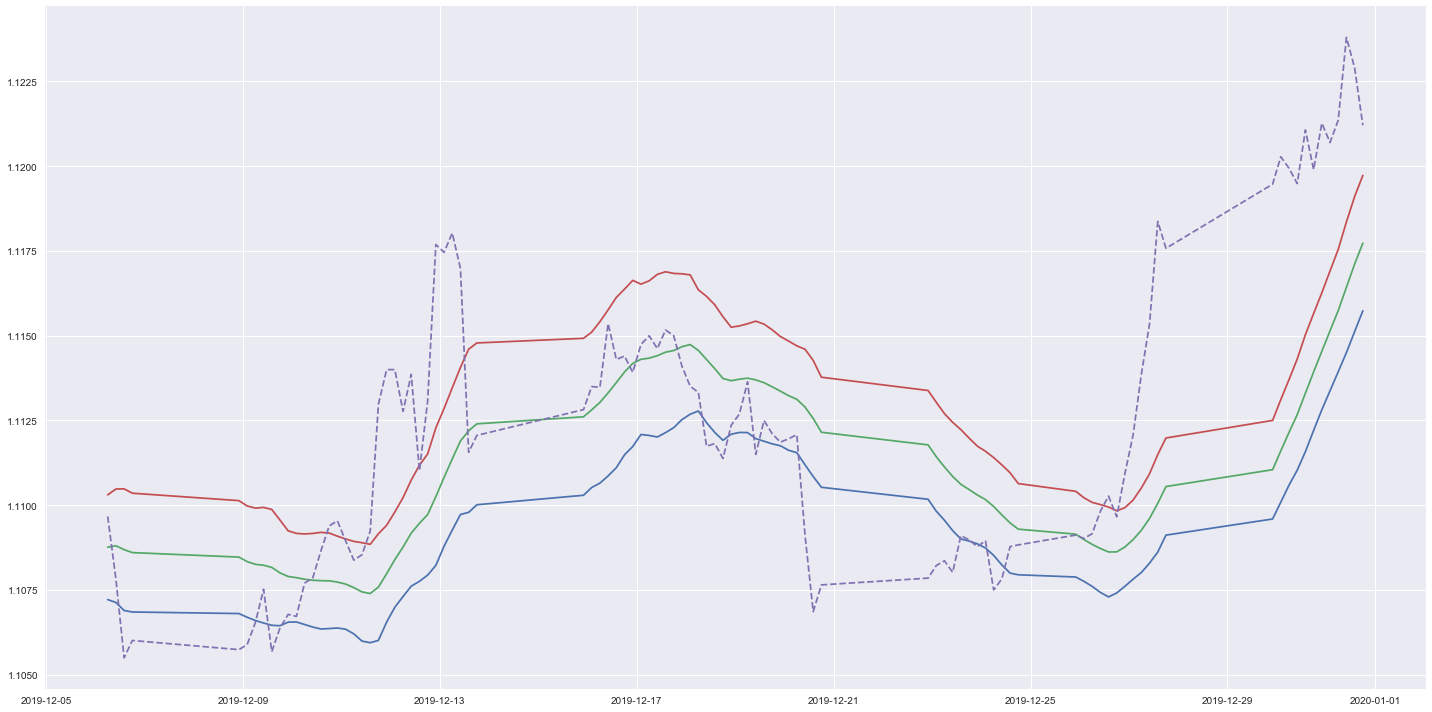

In [38]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["KCL_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["KCB_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["KCU_20"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Know Sure Thing (KST)

'Know Sure Thing' (KST)

The 'Know Sure Thing' is a momentum based oscillator and based on ROC.

Sources: https://www.tradingview.com/wiki/Know_Sure_Thing_(KST) https://www.incrediblecharts.com/indicators/kst.php

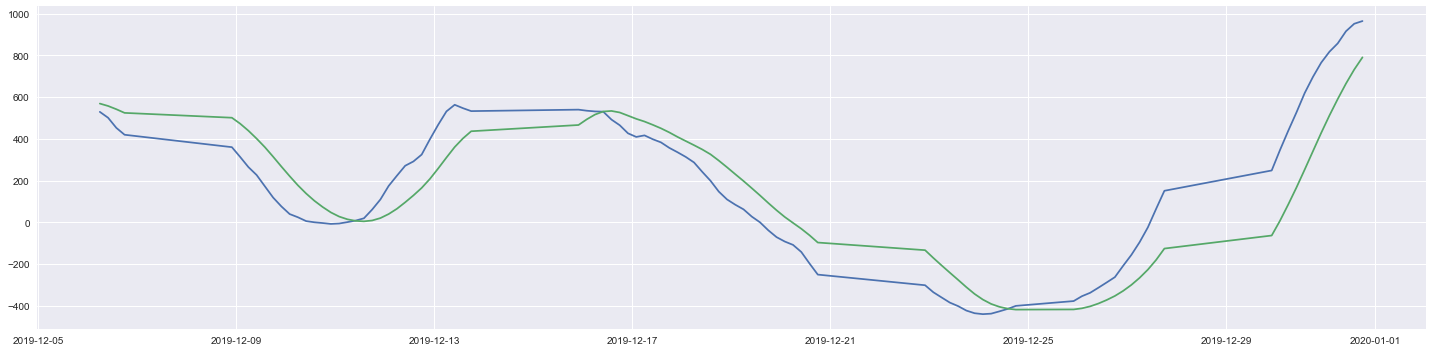

In [39]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["KST_10_15_20_30_10_10_10_15"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["KSTS_9"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Kurtosis

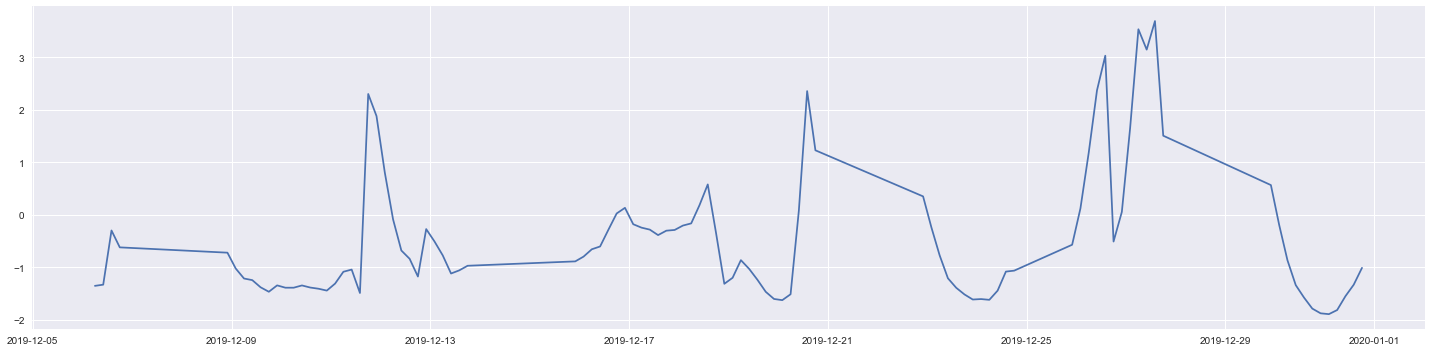

In [40]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["Kurtosis"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Linear Regression Moving Average (linreg)

Linear Regression Moving Average (linreg)

Linear Regression Moving Average

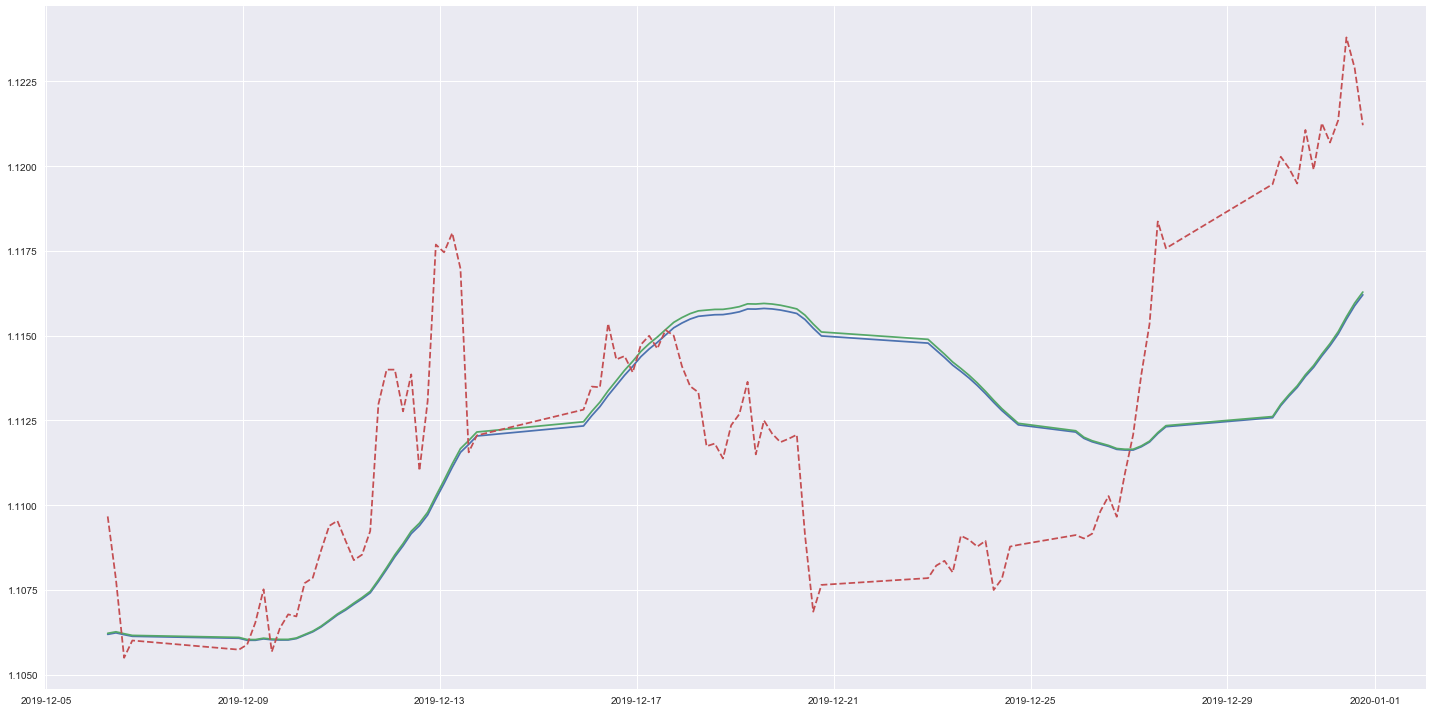

In [41]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["linreg"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["linreg_tsf"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Log Return

Log Return

Calculates the logarithmic return of a Series. See also: help(df.ta.log_return) for additional **kwargs a valid 'df'.

Sources: https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe

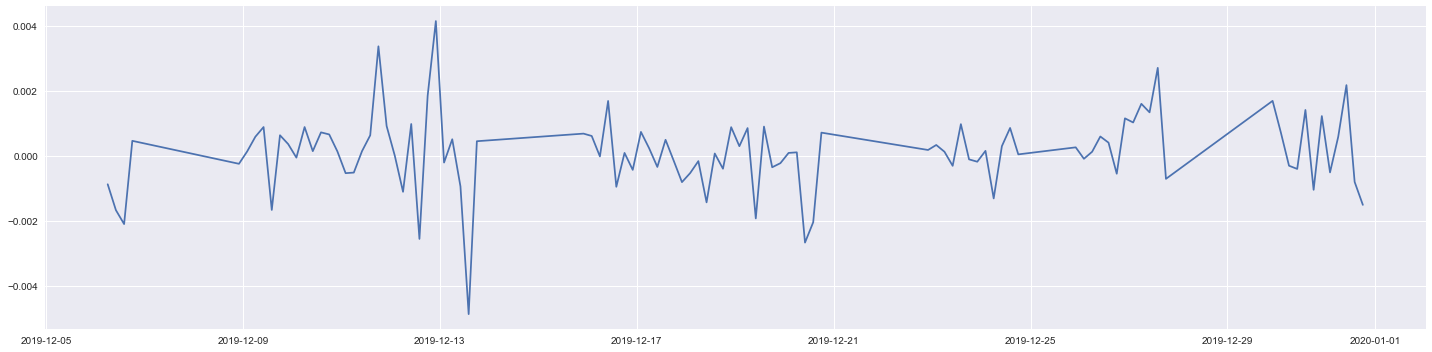

In [42]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["log_return"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Mass Index

Mass Index (MASSI)

The Mass Index is a non-directional volatility indicator that utilitizes the High-Low Range to identify trend reversals based on range expansions.

Sources: https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:mass_index mi = sum(ema(high - low, 9) / ema(ema(high - low, 9), 9), length)

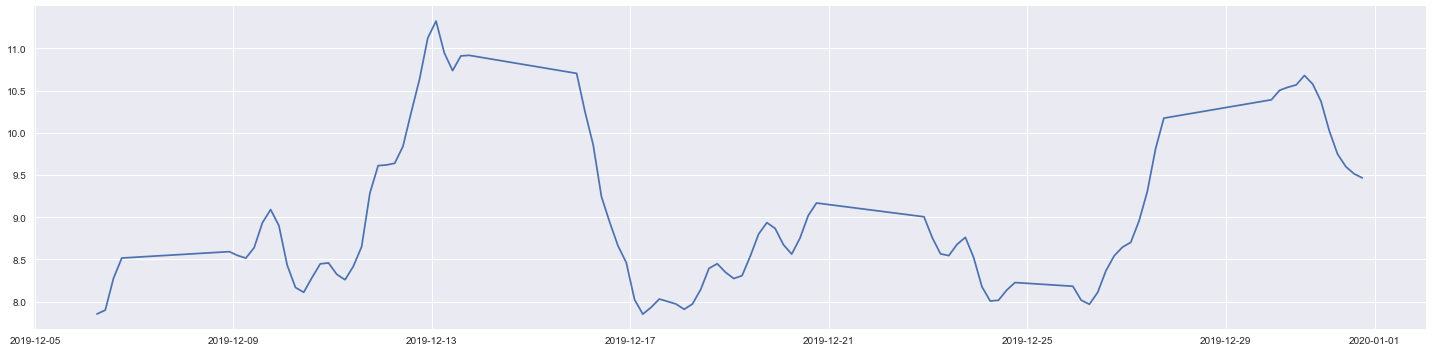

In [43]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["MI"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Median 

Rolling Median

Rolling Median of over 'n' periods. Sibling of a Simple Moving Average.

Sources: https://www.incrediblecharts.com/indicators/median_price.php

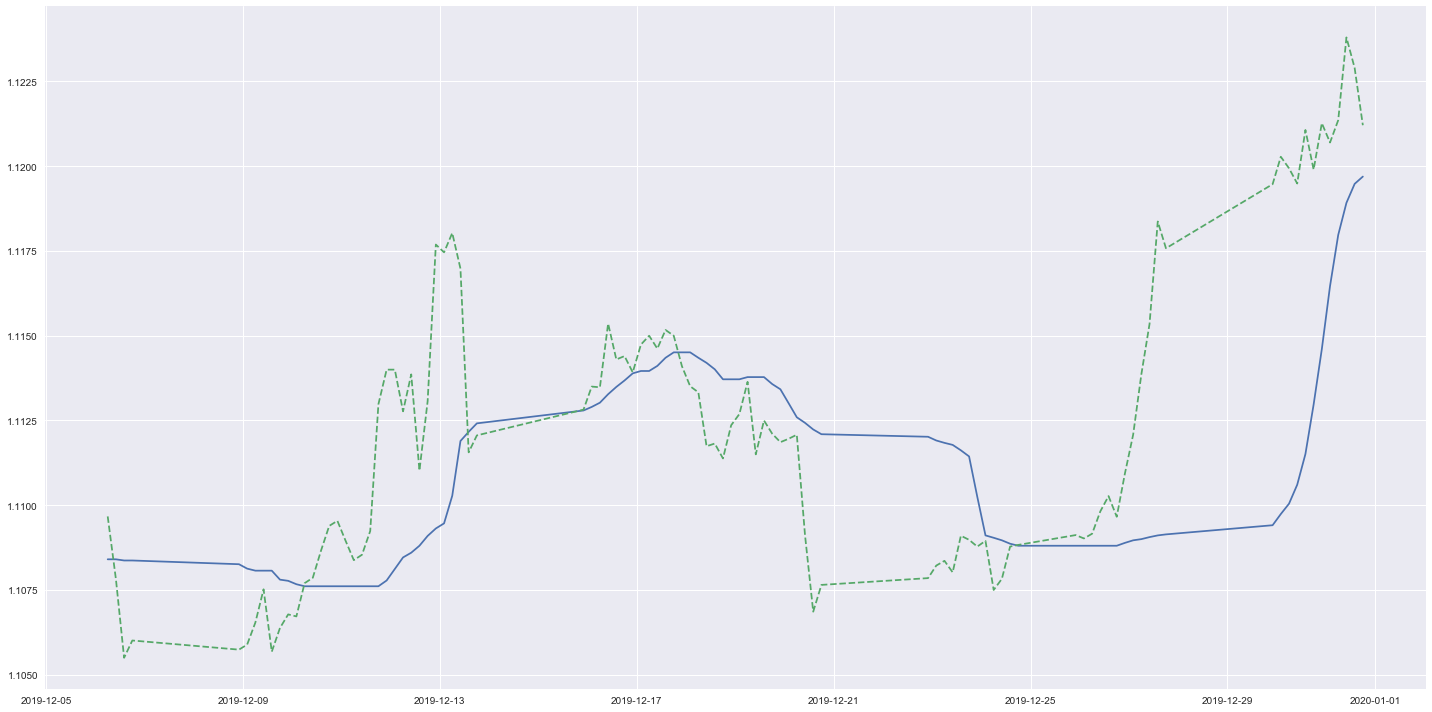

In [44]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["median"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Momentum (MOM)

Momentum (MOM)

Momentum is an indicator used to measure a security's speed (or strength) of movement. Or simply the change in price.

Sources: http://www.onlinetradingconcepts.com/TechnicalAnalysis/Momentum.html

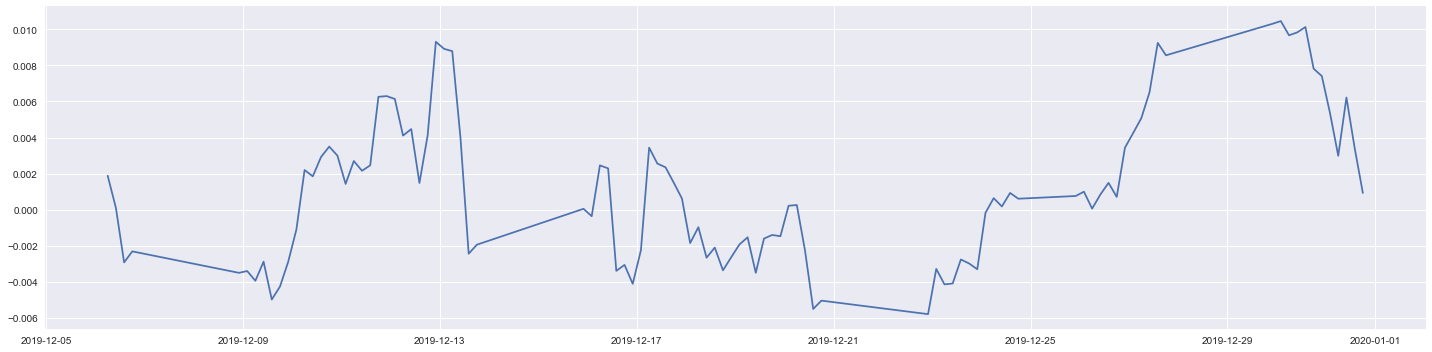

In [45]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["MOM"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# On Balance Volume (OBV)

On Balance Volume (OBV)

On Balance Volume is a cumulative indicator to measure buying and selling pressure.

Sources: https://www.tradingview.com/wiki/On_Balance_Volume_(OBV) https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/on-balance-volume-obv/ https://www.motivewave.com/studies/on_balance_volume.htm

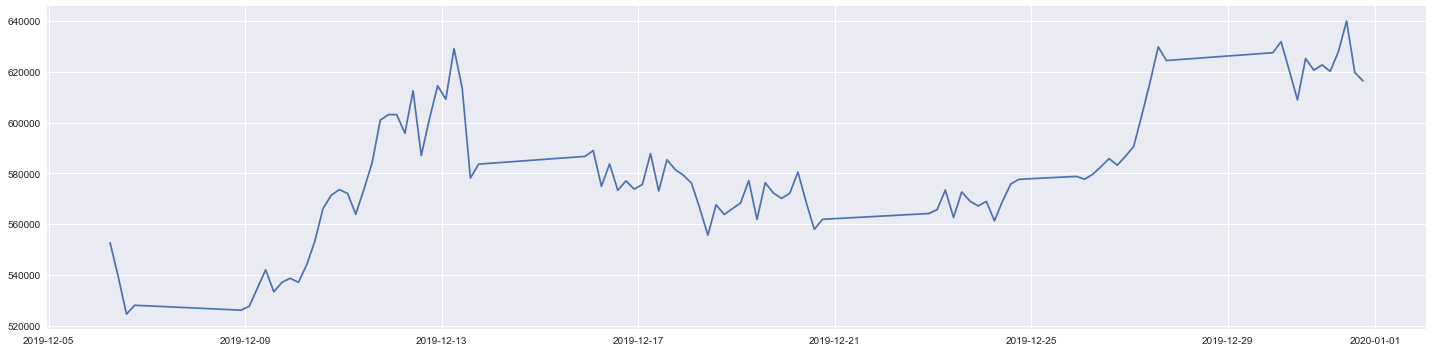

In [46]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["OBV"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Negative Volume Index (NVI)

Negative Volume Index (NVI)

The Negative Volume Index is a cumulative indicator that uses volume change in an attempt to identify where smart money is active.

Sources: https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:negative_volume_inde https://www.motivewave.com/studies/negative_volume_index.htm

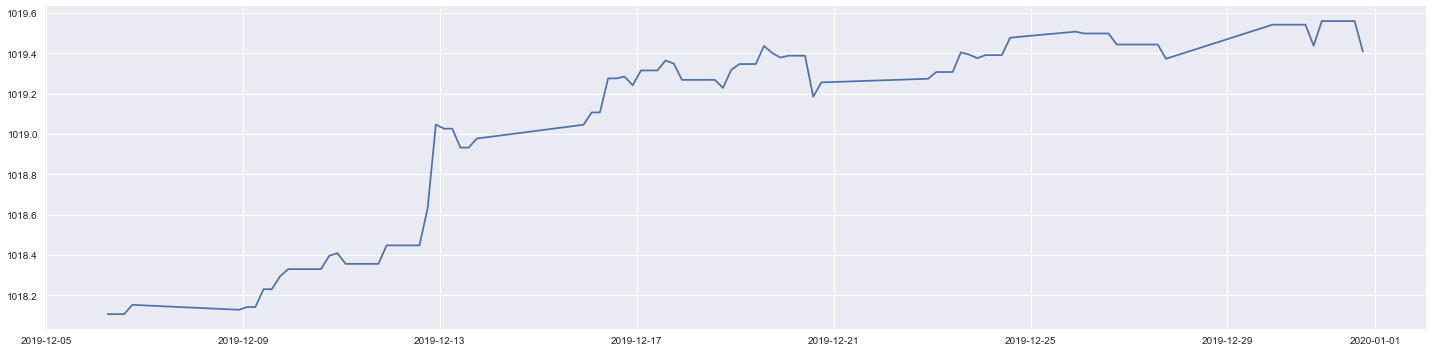

In [47]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["NVI"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Positive Volume Index (PVI)

Positive Volume Index (PVI)

The Positive Volume Index is a cumulative indicator that uses volume change in an attempt to identify where smart money is active. Used in conjunction with NVI.

Sources: https://www.investopedia.com/terms/p/pvi.asp

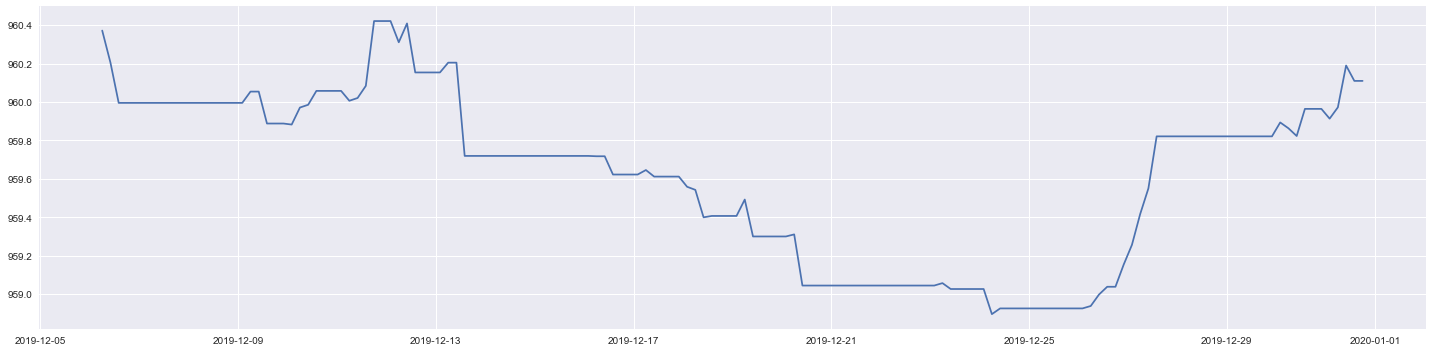

In [48]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["PVI"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Price Volume Trend (PVT)

Price-Volume Trend (PVT)

The Price-Volume Trend utilizes the Rate of Change with volume to and it's cumulative values to determine money flow.

Sources: https://www.tradingview.com/wiki/Price_Volume_Trend_(PVT)

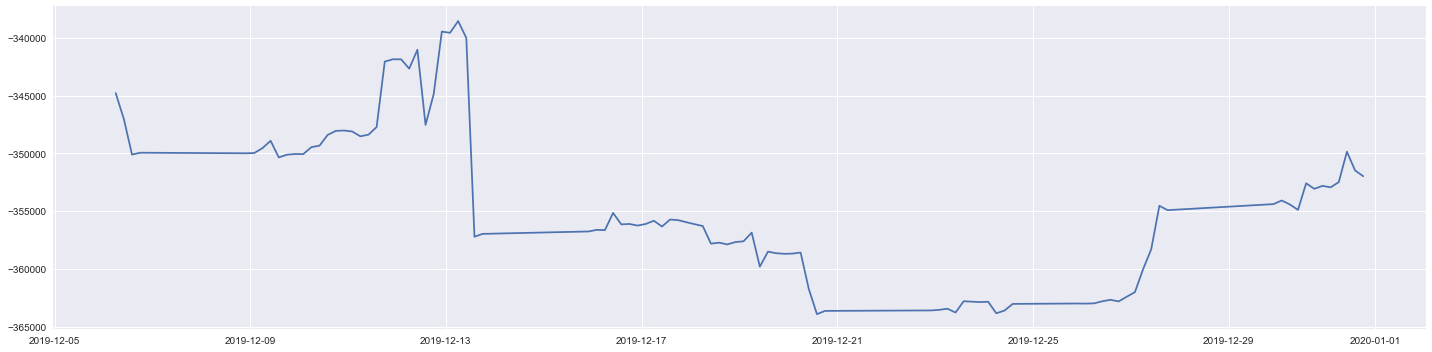

In [49]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["PVT"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Q Stick

Q Stick

The Q Stick indicator, developed by Tushar Chande, attempts to quantify and identify trends in candlestick charts.

Sources: https://library.tradingtechnologies.com/trade/chrt-ti-qstick.html

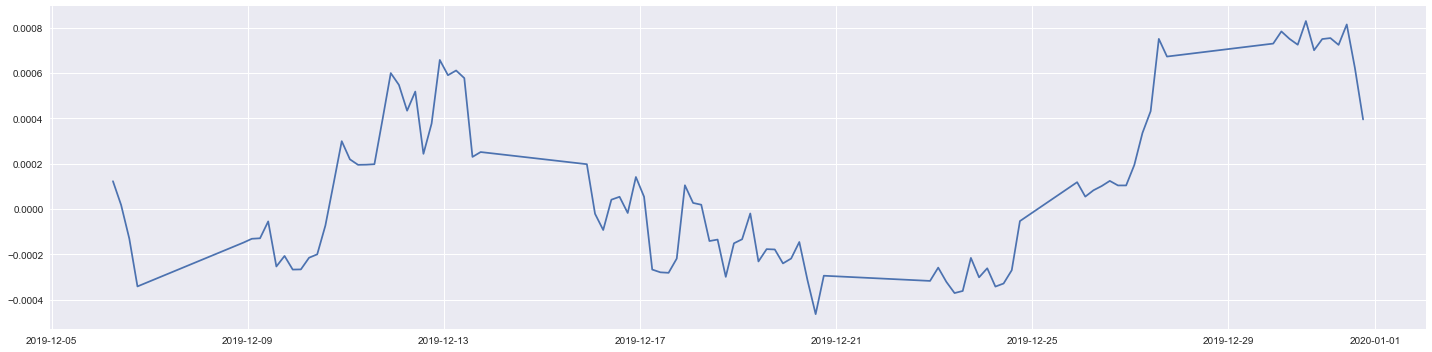

In [50]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["Qstick"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Rate of Change (ROG)

Rate of Change (ROC)

Rate of Change is an indicator is also referred to as Momentum (yeah, confusingly). It is a pure momentum oscillator that measures the percent change in price with the previous price 'n' (or length) periods ago.

Sources: https://www.tradingview.com/wiki/Rate_of_Change_(ROC)

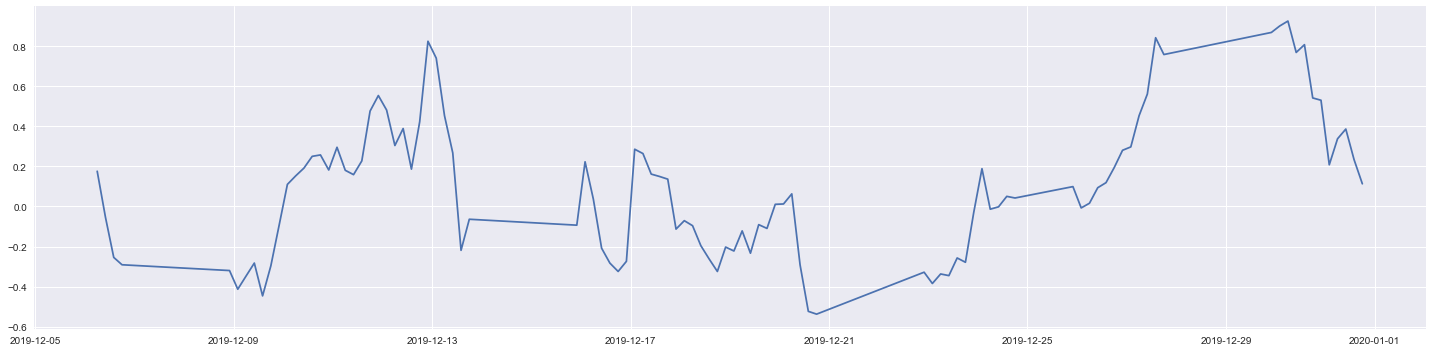

In [51]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["ROC"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Relative Viger Index (RVI)

Relative Vigor Index (RVI)

The Relative Vigor Index attempts to measure the strength of a trend relative to its closing price to its trading range. It is based on the belief that it tends to close higher than they open in uptrends or close lower than they open in downtrends.

Sources: https://www.investopedia.com/terms/r/relative_vigor_index.asp

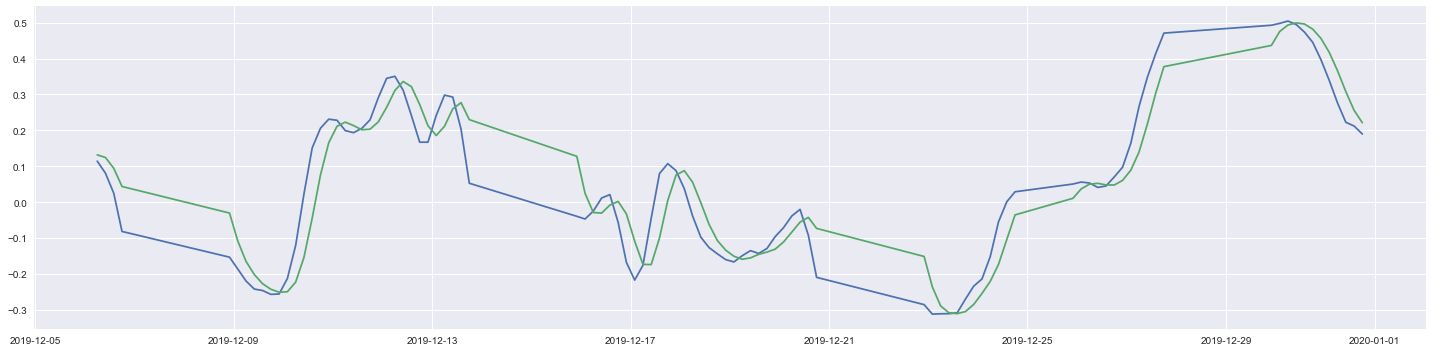

In [52]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["RVI_10_4"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["RVIS_10_4"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Skewness

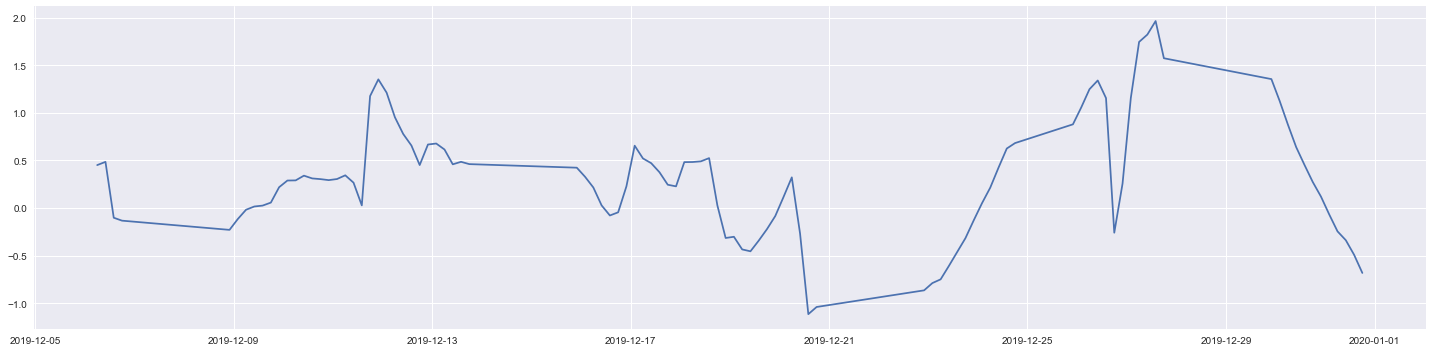

In [53]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["skew"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Standard Deviation 

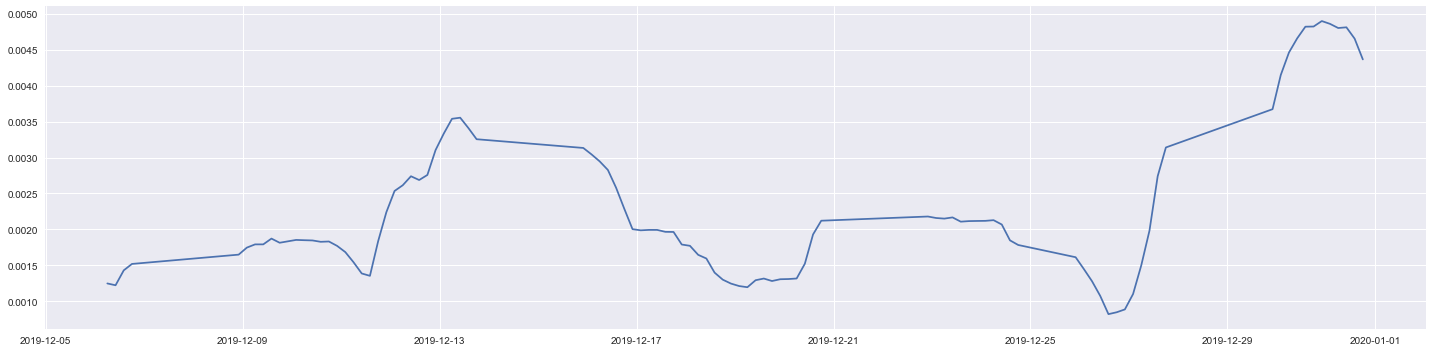

In [54]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["stdev"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Stochastic (STOCH)

Stochastic (STOCH)

Stochastic Oscillator is a range bound momentum indicator. It displays the location of the close relative to the high-low range over a period.

Sources: https://www.tradingview.com/wiki/Stochastic_(STOCH)

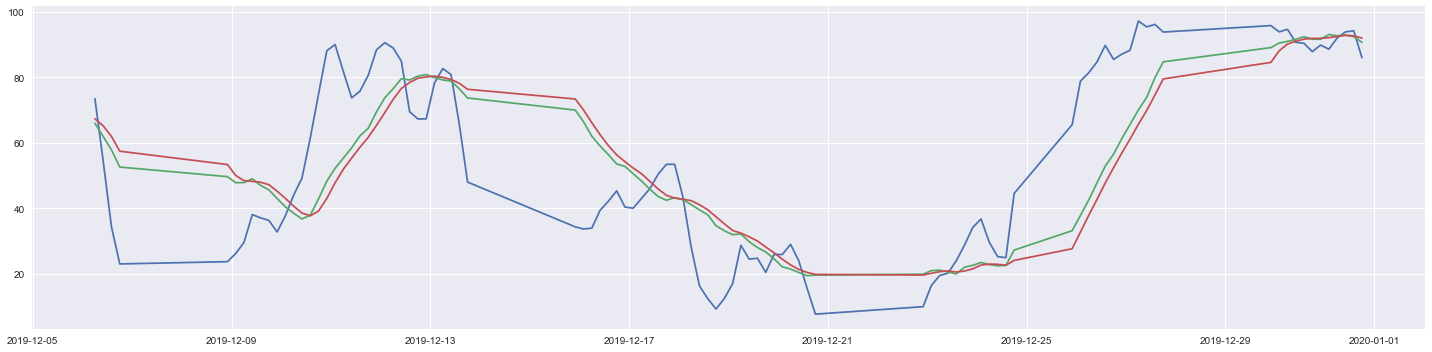

In [55]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["STOCHF_3"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["STOCH_14"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data["STOCH_3"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Tim Tillson's T3 Moving Average (T3)

Tim Tillson's T3 Moving Average (T3)

Tim Tillson's T3 Moving Average is considered a smoother and more responsive moving average relative to other moving averages.

Sources: http://www.binarytribune.com/forex-trading-indicators/t3-moving-average-indicator/

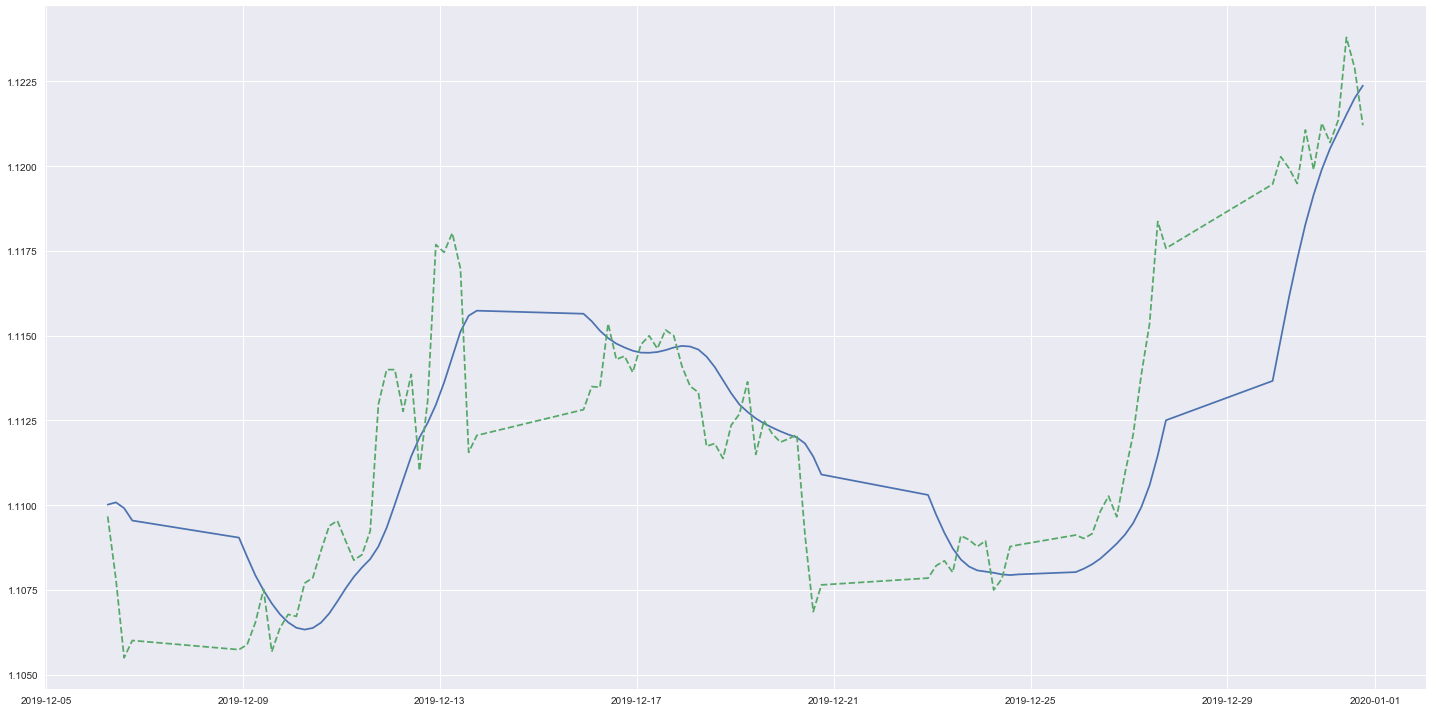

In [56]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["T3"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Triple Exponential Moving Average (TEMA)

Triple Exponential Moving Average (TEMA)

A less laggy Exponential Moving Average.

Sources: https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/triple-exponential-moving-average-tema/

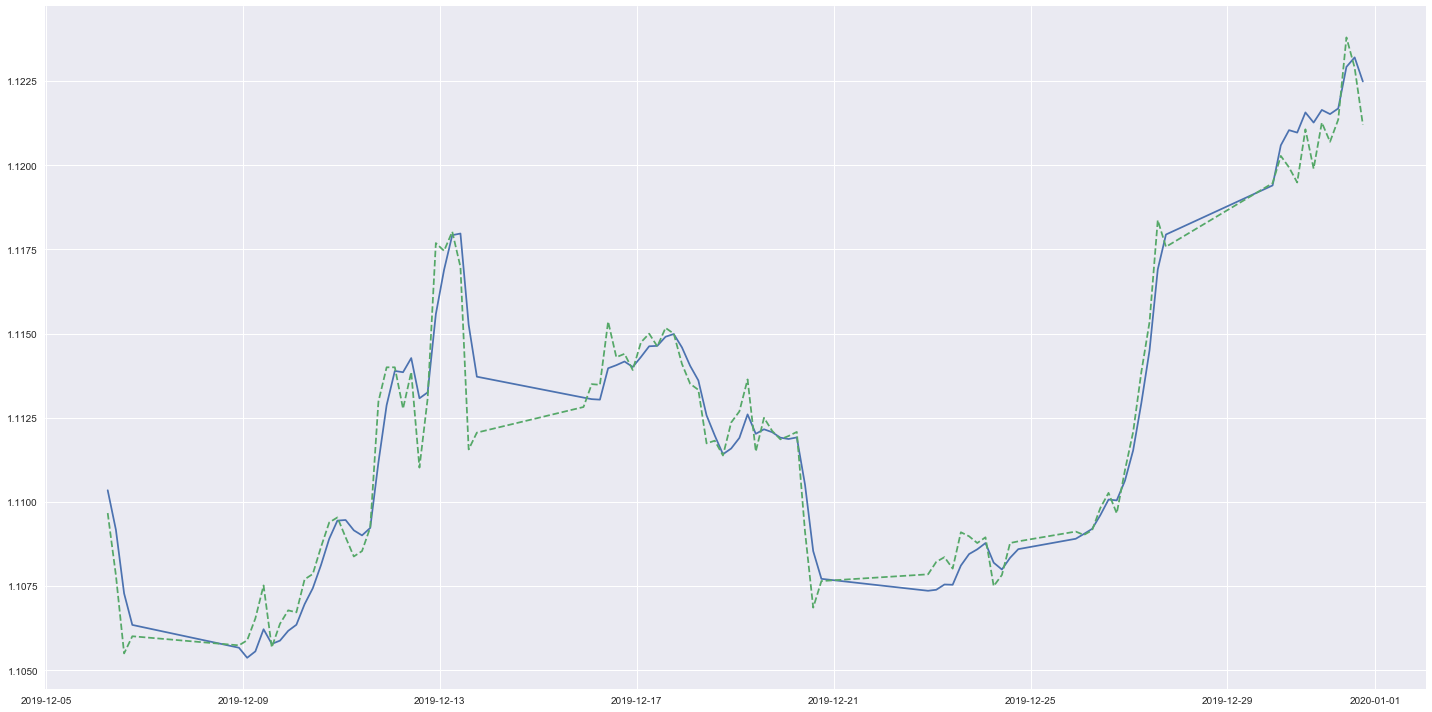

In [57]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["TEMA"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# Trix (TRIX)

Trix (TRIX)

TRIX is a momentum oscillator to identify divergences.

Sources: https://www.tradingview.com/wiki/TRIX

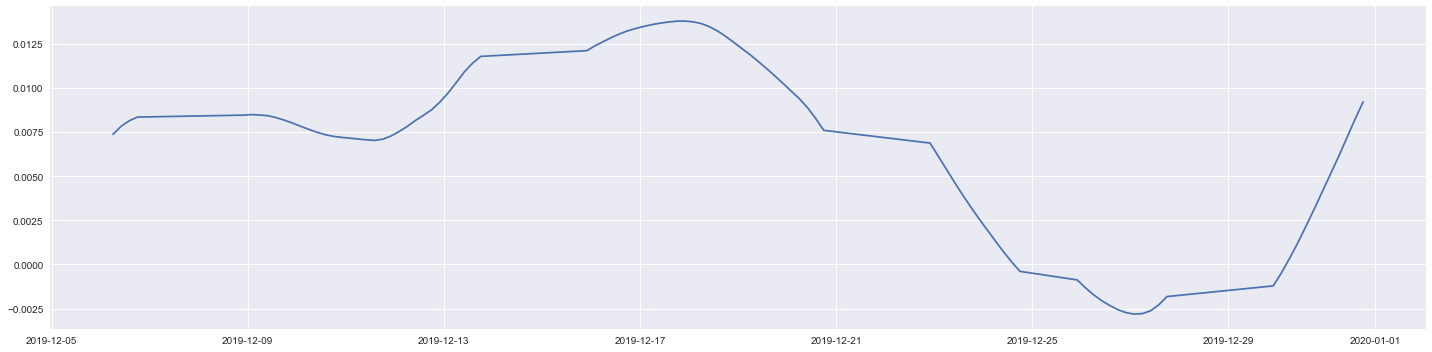

In [58]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["TRIX"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# True Strength Index (TSI)

True Strength Index (TSI)

The True Strength Index is a momentum indicator used to identify short-term swings while in the direction of the trend as well as determining overbought and oversold conditions.

Sources: https://www.investopedia.com/terms/t/tsi.asp

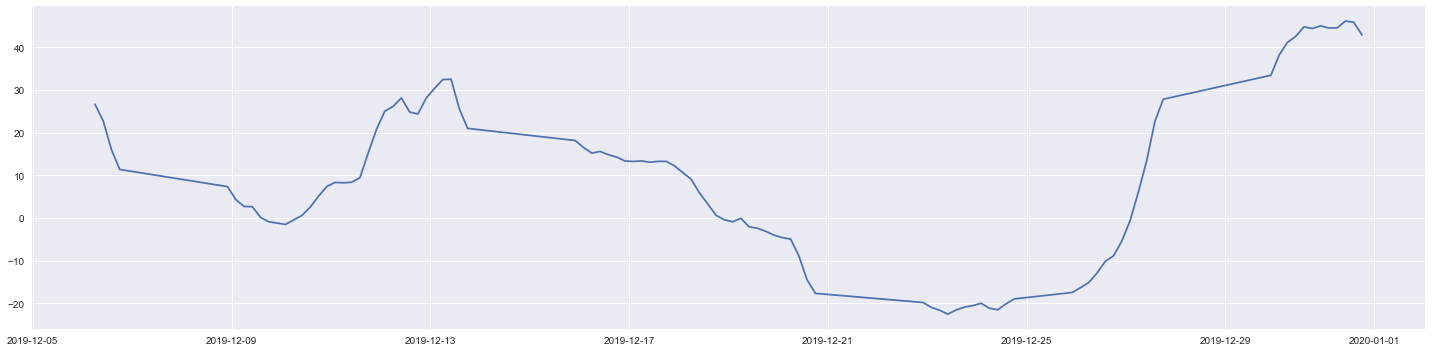

In [59]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["TSI"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Ultimate Oscillator (UO)

Ultimate Oscillator (UO)

The Ultimate Oscillator is a momentum indicator over three different periods. It attempts to correct false divergence trading signals.

Sources: https://www.tradingview.com/wiki/Ultimate_Oscillator_(UO)

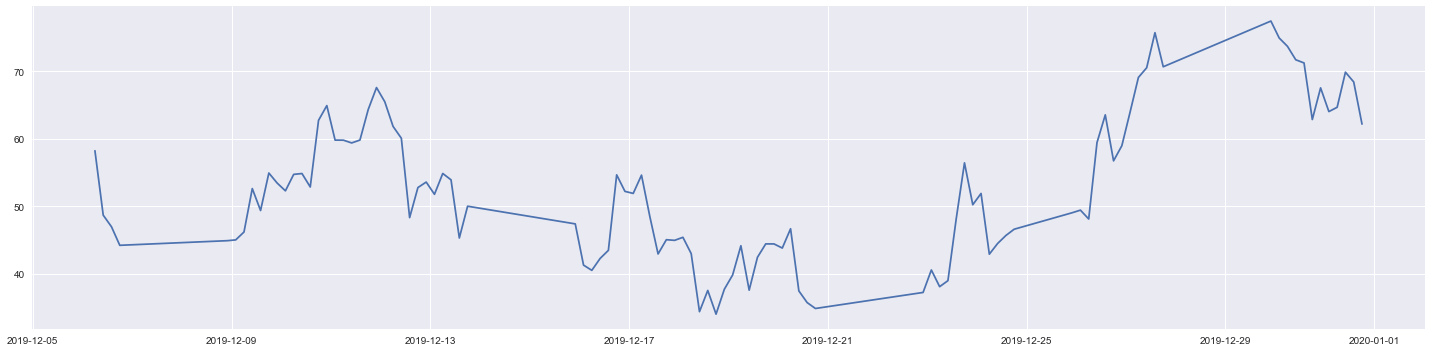

In [60]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["UO"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Volume Weighted Average Price (VWAP)

Volume Weighted Average Price (VWAP)

The Volume Weighted Average Price that measures the average typical price by volume. It is typically used with intraday charts to identify general direction.

Sources: https://www.tradingview.com/wiki/Volume_Weighted_Average_Price_(VWAP) https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/volume-weighted-average-price-vwap/

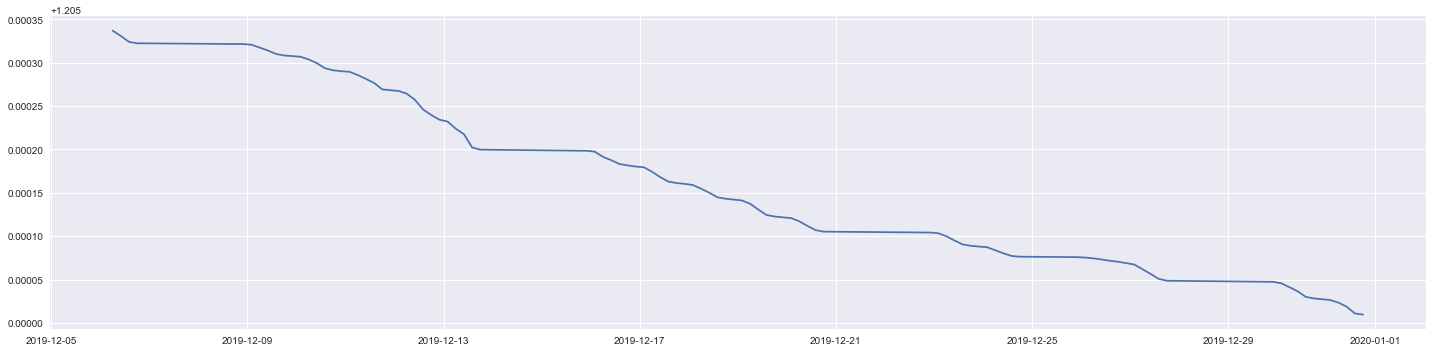

In [61]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["VWAP"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

# Volume Weighted Moving Average (VWMA)

Volume Weighted Moving Average (VWMA)

Volume Weighted Moving Average.

Sources: https://www.motivewave.com/studies/volume_weighted_moving_average.htm

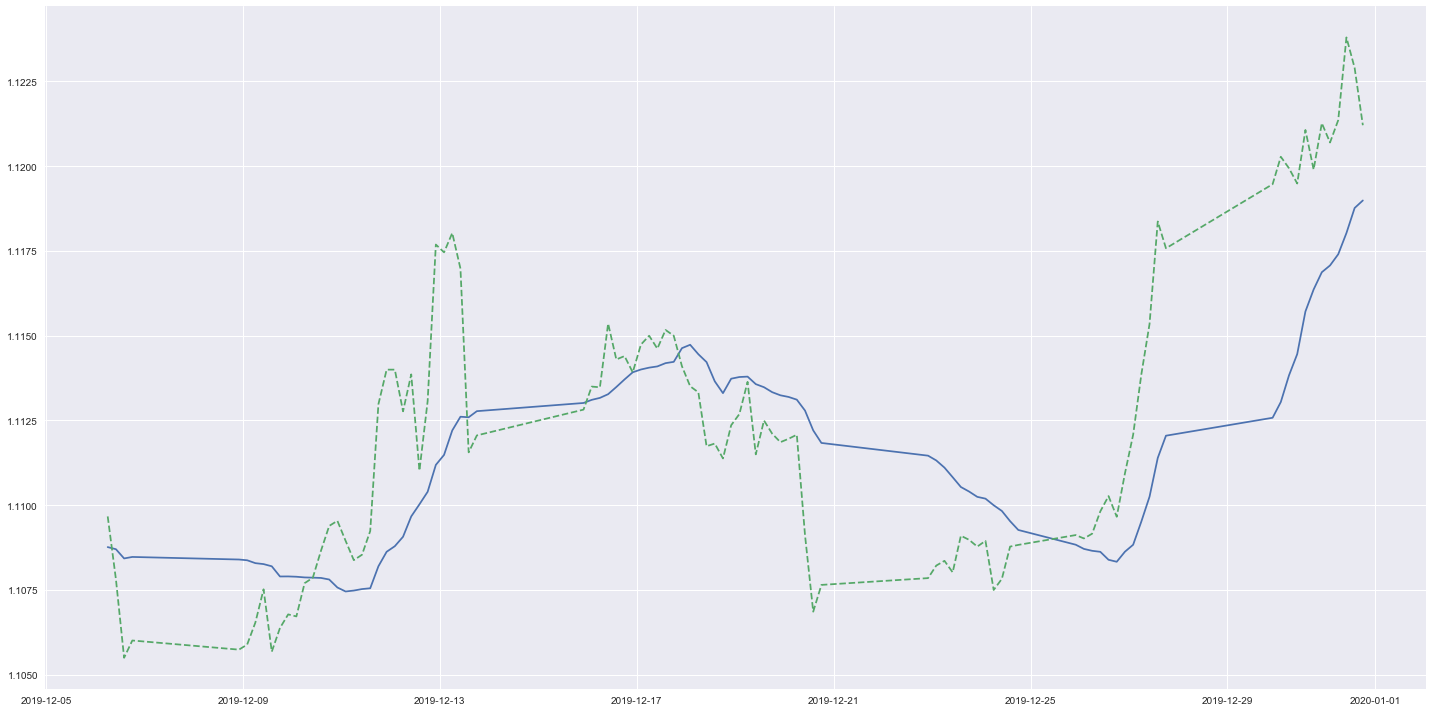

In [62]:
plt.figure(figsize=(20,10))
plt.plot_date(time, data["VWMA"].tail(n), linestyle="solid", marker=None)
plt.plot_date(time, data[f'close_{instrument}'].tail(n), linestyle="--", marker=None, label= "Price")
plt.tight_layout()
plt.show()

# William's Percent R (WILLR)

William's Percent R (WILLR)

William's Percent R is a momentum oscillator similar to the RSI that attempts to identify overbought and oversold conditions.

Sources: https://www.tradingview.com/wiki/Williams_%25R_(%25R)

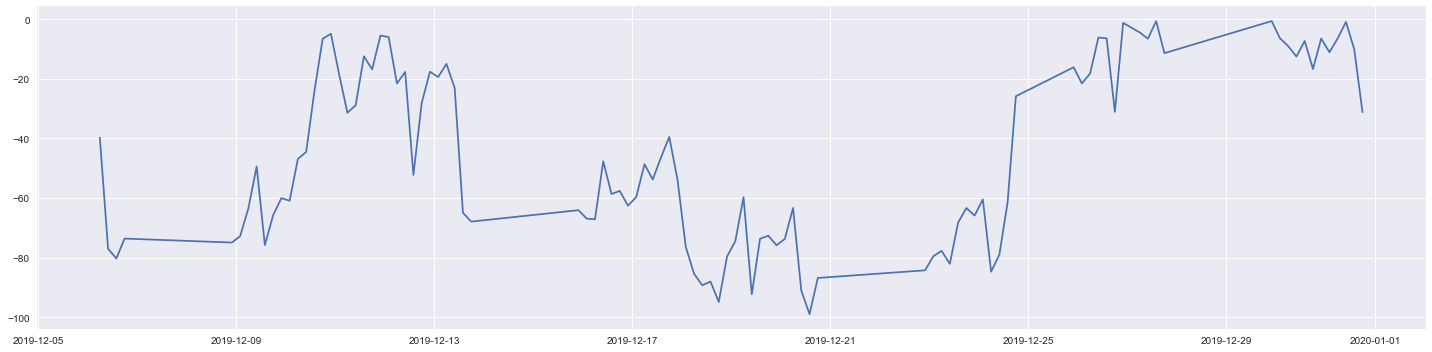

In [63]:
plt.figure(figsize=(20,5))
plt.plot_date(time, data["WILLR"].tail(n), linestyle="solid", marker=None)
plt.tight_layout()
plt.show()

## Now we have a dataset that we can work with 

In [64]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
data = pd.read_csv('dataset/ta_EUR_USD.csv', index_col=['time_EUR_USD'])
data

close_EUR_USD  open_EUR_USD  high_EUR_USD  \
time_EUR_USD                                                                
2010-01-03T14:00:00.000000000Z        1.43172       1.43120       1.43172   
2010-01-03T18:00:00.000000000Z        1.43036       1.43172       1.43425   
2010-01-03T22:00:00.000000000Z        1.42714       1.43030       1.43358   
2010-01-04T02:00:00.000000000Z        1.43012       1.42712       1.43089   
2010-01-04T06:00:00.000000000Z        1.43948       1.43010       1.43964   
...                                       ...           ...           ...   
2019-12-31T02:00:00.000000000Z        1.12070       1.12126       1.12148   
2019-12-31T06:00:00.000000000Z        1.12136       1.12070       1.12176   
2019-12-31T10:00:00.000000000Z        1.12380       1.12138       1.12391   
2019-12-31T14:00:00.000000000Z        1.12290       1.12381       1.12393   
2019-12-31T18:00:00.000000000Z        1.12121       1.12289       1.12290   

                                low_EUR_USD  Volume_EUR_USD  Histogram  \
time_EUR_USD                                                             
2010-01-03T14:00:00.000000000Z      1.43120               3        NaN   
2010-01-03T18:00:00.000000000Z      1.42926            1024        NaN   
2010-01-03T22:00:00.000000000Z      1.42576            5994        NaN   
2010-01-04T02:00:00.000000000Z      1.42708            2836        NaN   
2010-01-04T06:00:00.000000000Z      1.42694            9020        NaN   
...                                     ...             ...        ...   
2019-12-31T02:00:00.000000000Z      1.11988            2514   0.002867   
2019-12-31T06:00:00.000000000Z      1.12031            7702   0.002881   
2019-12-31T10:00:00.000000000Z      1.12086           12080   0.003055   
2019-12-31T14:00:00.000000000Z      1.12162           20217   0.003084   
2019-12-31T18:00:00.000000000Z      1.12102            3345   0.002937   

                                    MACD    Signal    SMA_10    SMA_25  ...  \
time_EUR_USD                                                            ...   
2010-01-03T14:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-03T18:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-03T22:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-04T02:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-04T06:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
...                                  ...       ...       ...       ...  ...   
2019-12-31T02:00:00.000000000Z  0.000553  0.002314  1.119807  1.113970  ...   
2019-12-31T06:00:00.000000000Z  0.000454  0.002427  1.120106  1.114466  ...   
2019-12-31T10:00:00.000000000Z  0.000502  0.002553  1.120728  1.115118  ...   
2019-12-31T14:00:00.000000000Z  0.000425  0.002659  1.121071  1.115721  ...   
2019-12-31T18:00:00.000000000Z  0.000222  0.002715  1.121164  1.116218  ...   

                                 STOCH_14    STOCH_3        T3      TEMA  \
time_EUR_USD                                                               
2010-01-03T14:00:00.000000000Z        NaN        NaN       NaN       NaN   
2010-01-03T18:00:00.000000000Z        NaN        NaN       NaN       NaN   
2010-01-03T22:00:00.000000000Z        NaN        NaN       NaN       NaN   
2010-01-04T02:00:00.000000000Z        NaN        NaN       NaN       NaN   
2010-01-04T06:00:00.000000000Z        NaN        NaN       NaN       NaN   
...                                   ...        ...       ...       ...   
2019-12-31T02:00:00.000000000Z  93.070734  92.119745  1.120520  1.121522   
2019-12-31T06:00:00.000000000Z  92.700719  92.471151  1.121022  1.121690   
2019-12-31T10:00:00.000000000Z  92.837448  92.869633  1.121524  1.122924   
2019-12-31T14:00:00.000000000Z  92.435479  92.657882  1.122007  1.123207   
2019-12-31T18:00:00.000000000Z  90.676682  91.983203  1.122379  1.122492   

                                    TRIX        TS

## Lets check for missing values

In [66]:
for i in data.columns:
    print({i:{'Missing Values':data.isna().sum()[i]}})

{'close_EUR_USD': {'Missing Values': 0}}
{'open_EUR_USD': {'Missing Values': 0}}
{'high_EUR_USD': {'Missing Values': 0}}
{'low_EUR_USD': {'Missing Values': 0}}
{'Volume_EUR_USD': {'Missing Values': 0}}
{'Histogram': {'Missing Values': 25}}
{'MACD': {'Missing Values': 26}}
{'Signal': {'Missing Values': 26}}
{'SMA_10': {'Missing Values': 9}}
{'SMA_25': {'Missing Values': 24}}
{'SMA_50': {'Missing Values': 49}}
{'SMA_100': {'Missing Values': 99}}
{'SMA_150': {'Missing Values': 149}}
{'SMA_200': {'Missing Values': 199}}
{'RSI': {'Missing Values': 1}}
{'ACCE_H': {'Missing Values': 19}}
{'ACCE_L': {'Missing Values': 19}}
{'ACCE_C': {'Missing Values': 19}}
{'AD': {'Missing Values': 0}}
{'ADOSC': {'Missing Values': 9}}
{'AMAT_LR_2': {'Missing Values': 0}}
{'AMAT_SR_2': {'Missing Values': 0}}
{'AO': {'Missing Values': 4}}
{'OBV': {'Missing Values': 0}}
{'OBV_min_2': {'Missing Values': 1}}
{'OBV_max_2': {'Missing Values': 1}}
{'OBV_EMA_2': {'Missing Values': 1}}
{'OBV_EMA_4': {'Missing Values': 

In [67]:
data.dropna(inplace=True)

## We can clean the data by droping the missing values using pandas

In [68]:
for i in data.columns:
    print({i:{'Missing Values':data.isna().sum()[i]}})

{'close_EUR_USD': {'Missing Values': 0}}
{'open_EUR_USD': {'Missing Values': 0}}
{'high_EUR_USD': {'Missing Values': 0}}
{'low_EUR_USD': {'Missing Values': 0}}
{'Volume_EUR_USD': {'Missing Values': 0}}
{'Histogram': {'Missing Values': 0}}
{'MACD': {'Missing Values': 0}}
{'Signal': {'Missing Values': 0}}
{'SMA_10': {'Missing Values': 0}}
{'SMA_25': {'Missing Values': 0}}
{'SMA_50': {'Missing Values': 0}}
{'SMA_100': {'Missing Values': 0}}
{'SMA_150': {'Missing Values': 0}}
{'SMA_200': {'Missing Values': 0}}
{'RSI': {'Missing Values': 0}}
{'ACCE_H': {'Missing Values': 0}}
{'ACCE_L': {'Missing Values': 0}}
{'ACCE_C': {'Missing Values': 0}}
{'AD': {'Missing Values': 0}}
{'ADOSC': {'Missing Values': 0}}
{'AMAT_LR_2': {'Missing Values': 0}}
{'AMAT_SR_2': {'Missing Values': 0}}
{'AO': {'Missing Values': 0}}
{'OBV': {'Missing Values': 0}}
{'OBV_min_2': {'Missing Values': 0}}
{'OBV_max_2': {'Missing Values': 0}}
{'OBV_EMA_2': {'Missing Values': 0}}
{'OBV_EMA_4': {'Missing Values': 0}}
{'AOBV_LR

## Let's standardize the data.

It is important to scale features before training a neural network. Scaling the data is common way of doing this scaling.  

In [69]:
scale_target = MinMaxScaler()

target = data['close_EUR_USD']
target = scale_target.fit_transform(target.values.reshape(-1, 1))

scale_data = MinMaxScaler(feature_range=(0, 1))
data = scale_data.fit_transform(data.values)
data

array([[7.09647638e-01, 7.11623000e-01, 7.07398043e-01, ...,
        1.00000000e+00, 7.32646706e-01, 4.03647416e-01],
       [7.15055063e-01, 7.09666784e-01, 7.11927009e-01, ...,
        9.99447102e-01, 7.31751905e-01, 5.56574924e-01],
       [7.19803047e-01, 7.15073853e-01, 7.17291415e-01, ...,
        9.98916170e-01, 7.30708374e-01, 7.24581725e-01],
       ...,
       [1.90842547e-01, 1.85510814e-01, 1.86325162e-01, ...,
        4.49437492e-05, 1.72797453e-01, 9.90946502e-01],
       [1.88864221e-01, 1.90851943e-01, 1.86369133e-01, ...,
        6.45343900e-06, 1.74466229e-01, 8.99707887e-01],
       [1.85149364e-01, 1.88829787e-01, 1.84104650e-01, ...,
        0.00000000e+00, 1.74967633e-01, 6.88430699e-01]])

# Multi-Step model

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values.
For the multi-step model, the training data consists of recordings over the past five days sampled every four hour. However, here, the model needs to learn to predict the EUR_USD Rats for the next 8 hours. Since an obversation is taken every 4 hours, the output is 2 predictions.

In [70]:
training_data = 10000

In [71]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                     target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [72]:
past_history = 120
future_target = 2
STEP = 1

x_train, y_train = multivariate_data(data, data[:, 1], 0,
                                                   training_data, past_history,
                                                   future_target, STEP)
x_test, y_test = multivariate_data(data, data[:, 1],
                                               training_data, None, past_history,
                                               future_target, STEP)

# Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.
In this project I will use a specialized RNN layer called Long Short Term Memory (LSTM)

## Let's now use tf.data to shuffle, batch, and cache the dataset.

In [73]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

This an example of how the data looks like

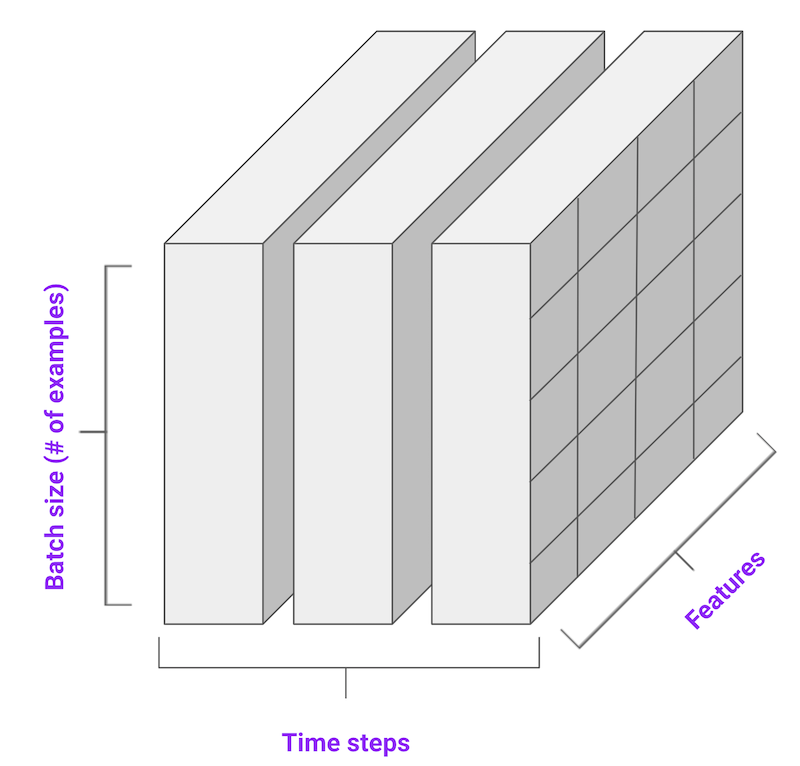

# Lets Build the Model 

In [74]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=x_train.shape[-2:]))

multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu'))

multi_step_model.add(tf.keras.layers.Dense(2))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0) ,loss='mae', metrics=['accuracy'])

earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.001,
  patience=3)

### Note I am using EarlyStopping 

In [75]:
EPOCHS = 10
EVALUATION = 2000
multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS, validation_data=val_data,
                                         steps_per_epoch=EVALUATION, validation_steps=50, 
                                         callbacks=[earlystop_callback])

Train for 2000 steps, validate for 50 steps
Epoch 1/10
2000/2000 [==============================] - 342s 171ms/step - loss: 77025268.1631 - accuracy: 0.5008 - val_loss: 120.6988 - val_accuracy: 0.5045
Epoch 2/10
2000/2000 [==============================] - 341s 171ms/step - loss: 102794.9690 - accuracy: 0.5006 - val_loss: 0.0362 - val_accuracy: 0.5080
Epoch 3/10
2000/2000 [==============================] - 336s 168ms/step - loss: 0.0268 - accuracy: 0.4967 - val_loss: 0.0206 - val_accuracy: 0.4970
Epoch 4/10
2000/2000 [==============================] - 333s 166ms/step - loss: 0.0151 - accuracy: 0.4961 - val_loss: 0.0137 - val_accuracy: 0.4998
Epoch 5/10
2000/2000 [==============================] - 350s 175ms/step - loss: 0.0124 - accuracy: 0.4980 - val_loss: 0.0119 - val_accuracy: 0.4974
Epoch 6/10
2000/2000 [==============================] - 348s 174ms/step - loss: 0.0111 - accuracy: 0.4994 - val_loss: 0.0114 - val_accuracy: 0.4954
Epoch 7/10
2000/2000 [==============================] 

In [76]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 19,170
Trainable params: 19,170
Non-trainable params: 0
_________________________________________________________________


## Plot the loss and val_loss

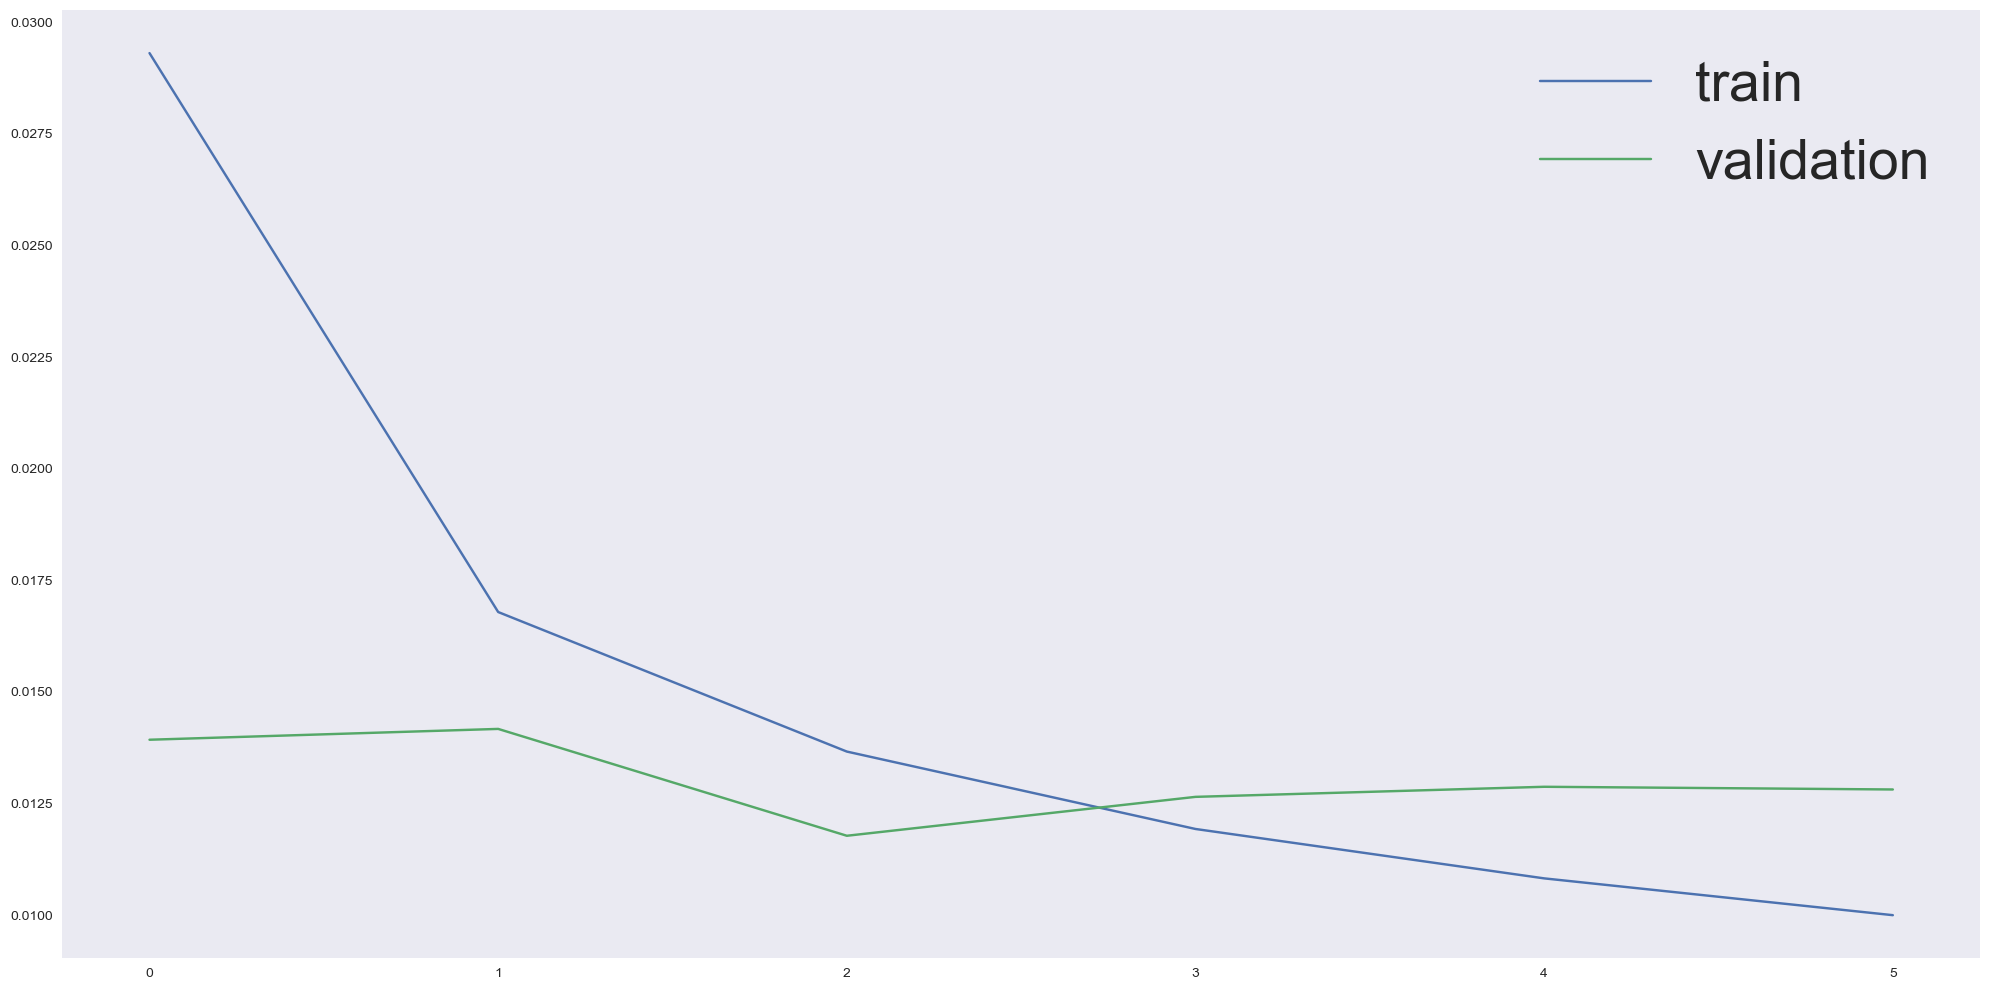

In [106]:
plt.figure(figsize=(20,10))
plt.plot(multi_step_history.history['loss'][-8:], label='train')
plt.plot(multi_step_history.history['val_loss'][-8:], label='validation')
plt.legend(fontsize=40)
plt.grid()
plt.tight_layout()
plt.show()

## Plotting a sample data-point.

In [78]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [79]:
def multi_step_plot(history, true_future, prediction):
    
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
        
    plt.grid()
    plt.tight_layout()    
    plt.legend(loc='upper left')
    plt.show()

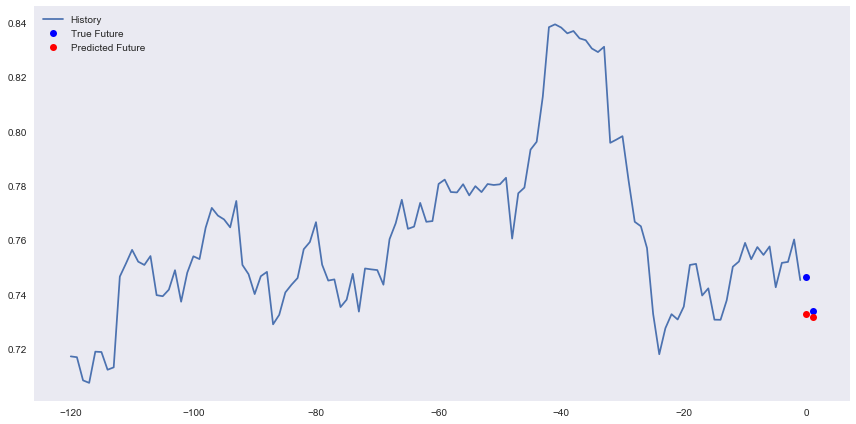

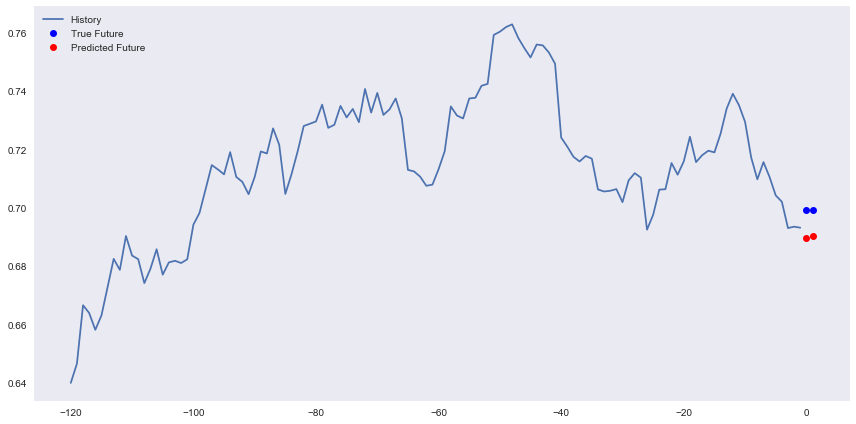

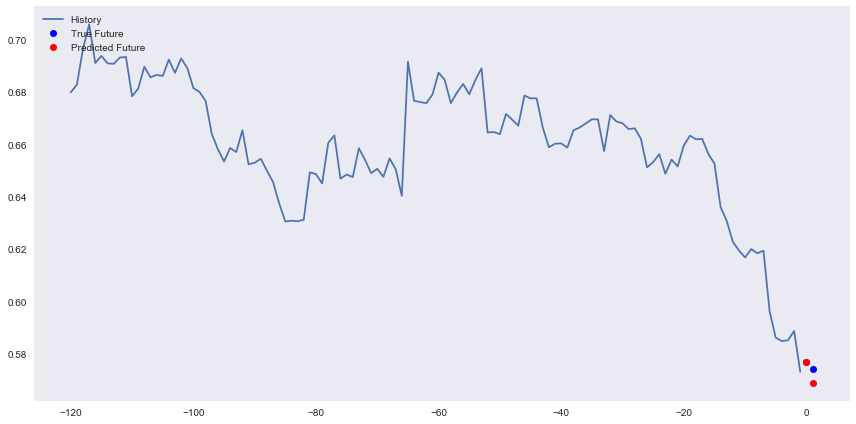

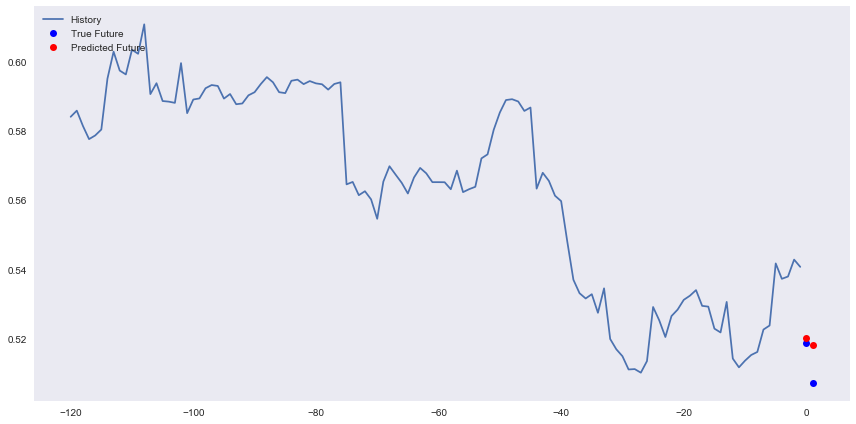

In [80]:
for x, y in train_data.take(4):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Features Selection

In [81]:
from feature_selector import FeatureSelector

In [82]:
train = pd.read_csv('dataset/ta_EUR_USD.csv', index_col=['time_EUR_USD'])

train_labels = train['close_EUR_USD']
train = train.drop(columns = ['close_EUR_USD'])
train.head()

open_EUR_USD  high_EUR_USD  low_EUR_USD  \
time_EUR_USD                                                              
2010-01-03T14:00:00.000000000Z       1.43120       1.43172      1.43120   
2010-01-03T18:00:00.000000000Z       1.43172       1.43425      1.42926   
2010-01-03T22:00:00.000000000Z       1.43030       1.43358      1.42576   
2010-01-04T02:00:00.000000000Z       1.42712       1.43089      1.42708   
2010-01-04T06:00:00.000000000Z       1.43010       1.43964      1.42694   

                                Volume_EUR_USD  Histogram  MACD  Signal  \
time_EUR_USD                                                              
2010-01-03T14:00:00.000000000Z               3        NaN   NaN     NaN   
2010-01-03T18:00:00.000000000Z            1024        NaN   NaN     NaN   
2010-01-03T22:00:00.000000000Z            5994        NaN   NaN     NaN   
2010-01-04T02:00:00.000000000Z            2836        NaN   NaN     NaN   
2010-01-04T06:00:00.000000000Z            9020        NaN   NaN     NaN   

                                SMA_10  SMA_25  SMA_50  ...  STOCH_14  \
time_EUR_USD                                            ...             
2010-01-03T14:00:00.000000000Z     NaN     NaN     NaN  ...       NaN   
2010-01-03T18:00:00.000000000Z     NaN     NaN     NaN  ...       NaN   
2010-01-03T22:00:00.000000000Z     NaN     NaN     NaN  ...       NaN   
2010-01-04T02:00:00.000000000Z     NaN     NaN     NaN  ...       NaN   
2010-01-04T06:00:00.000000000Z     NaN     NaN     NaN  ...       NaN   

                                STOCH_3  T3  TEMA  TRIX  TSI  UO      VWAP  \
time_EUR_USD                                                                 
2010-01-03T14:00:00.000000000Z      NaN NaN   NaN   NaN  NaN NaN  1.431547   
2010-01-03T18:00:00.000000000Z      NaN NaN   NaN   NaN  NaN NaN  1.431291   
2010-01-03T22:00:00.000000000Z      NaN NaN   NaN   NaN  NaN NaN  1.429187   
2010-01-04T02:00:00.000000000Z      NaN NaN   NaN   NaN  NaN NaN  1.429238   
2010-01-04T06:00:00.000000000Z      NaN NaN   NaN   NaN  NaN NaN  1.432160   

                                VWMA  WILLR  
time_EUR_USD                                 
2010-01-03T14:00:00.000000000Z   NaN    NaN  
2010-01-03T18:00:00.000000000Z   NaN    NaN  
2010-01-03T22:00:00.000000000Z   NaN    NaN  
2010-01-04T02:00:00.000000000Z   NaN    NaN  
2010-01-04T06:00:00.000000000Z   NaN    NaN  

[5 rows x 91 columns]

In [83]:
fs = FeatureSelector(data = train, labels = train_labels)

# 1. Collinear (highly correlated) Features

This method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed. We need to pass in a `correlation_threshold`. 

This method is based on code found at https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

For each pair, the feature that will be removed is the one that comes last in terms of the column ordering in the dataframe. (This method does not one-hot encode the data beforehand unless `one_hot=True`. Therefore correlations are only calculated between numeric columns)

In [84]:
fs.identify_collinear(correlation_threshold=0.975)

45 features with a correlation magnitude greater than 0.97.



In [85]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

['high_EUR_USD', 'low_EUR_USD', 'SMA_10', 'SMA_25', 'SMA_50']

We can view a heatmap of the correlations above the threhold. The features which will be dropped are on the x-axis. 

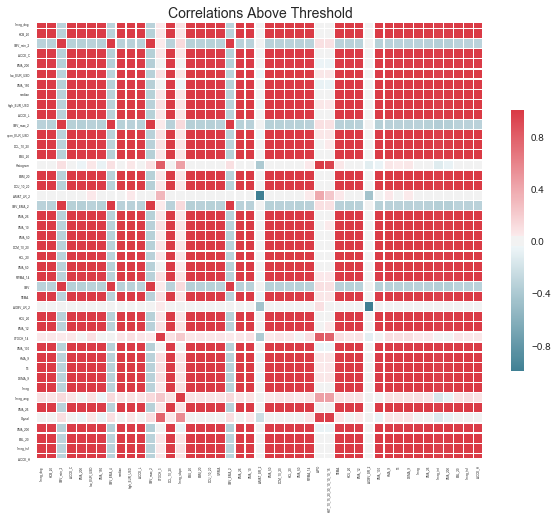

In [86]:
fs.plot_collinear()

To plot all of the correlations in the data, we can pass in `plot_all = True` to the `plot_collinear` function. 

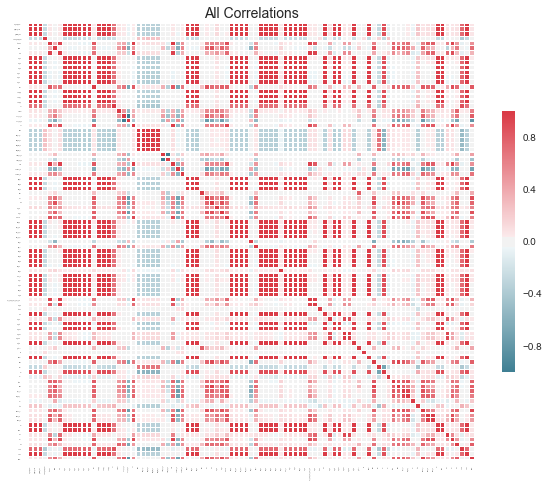

In [87]:
fs.plot_collinear(plot_all=True)

45 features with a correlation magnitude greater than 0.98.



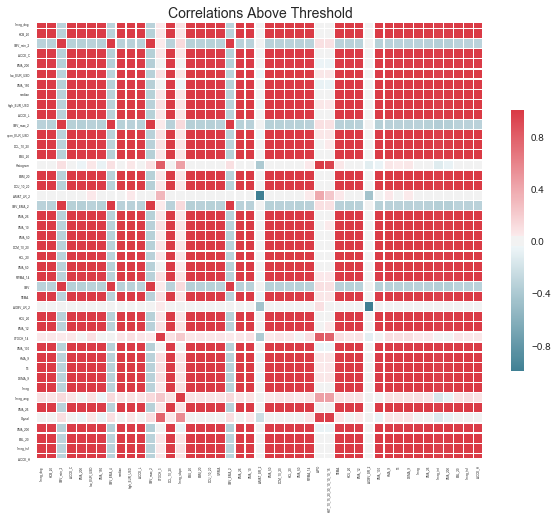

In [88]:
fs.identify_collinear(correlation_threshold=0.98)
fs.plot_collinear()

To view the details of the corelations above the threshold, we access the `record_collinear` attribute which is a dataframe. The `drop_feature` will be removed and for each feature that will be removed, there may be several correlations it has with the `corr_feature` that are above the `correlation_threshold`.

In [89]:
fs.record_collinear.head()

drop_feature  corr_feature  corr_value
0  high_EUR_USD  open_EUR_USD    0.999825
1   low_EUR_USD  open_EUR_USD    0.999826
2   low_EUR_USD  high_EUR_USD    0.999708
3        SMA_10  open_EUR_USD    0.999376
4        SMA_10  high_EUR_USD    0.999218

# 2. Zero Importance Features

This method relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. The method works by finding feature importances using a gradient boosting machine implemented in the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html). 

To reduce variance in the calculated feature importances, the model is trained a default 10 times. The model is also by default trained with early stopping using a validation set (15% of the training data) to identify the optimal number of estimators to train. The following parameters can be passed to the `identify_zero_importance` method:

* `task`: either `classification` or `regression`. The metric and labels must match with the task
* `eval_metric`: the metric used for early stopping (for example `auc` for classification or `l2` for regression). To see a list of available metrics, refer to the [LightGBM docs](http://testlightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters)
* `n_iterations`: number of training runs. The feature importances are averaged over the training runs (default = 10)
* `early_stopping`: whether to use early stopping when training the model (default = True). [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) stops training estimators (decision trees) when the performance on a validation set no longer decreases for a specified number of estimators (100 by default in this implementation). Early stopping is a form of regularization used to prevent overfitting to training data

The data is first one-hot encoded for use in the model. This means that some of the zero importance features may be created from one-hot encoding. To view the one-hot encoded columns, we can access the `one_hot_features` of the `FeatureSelector`.

__Note of caution__: in contrast to the other methods, the feature imporances from a model are non-deterministic (have a little randomness). The results of running this method can change each time it is run. 

In [90]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = False)

Training Gradient Boosting Model


4 features with zero importance after one-hot encoding.



Running the gradient boosting model requires one hot encoding the features. These features are saved in the `one_hot_features` attribute of the `FeatureSelector`. The original features are saved in the `base_features`.

In [91]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 91 original features
There are 0 one-hot features


The `data` attribute of the `FeatureSelector` holds the original dataframe. After one-hot encoding, the `data_all` attribute holds the original data plus the one-hot encoded features.

### Plot Feature Importances


The feature importance plot using `plot_feature_importances` will show us the `plot_n` most important features (on a normalized scale where the features sum to 1). It also shows us the cumulative feature importance versus the number of features. 

When we plot the feature importances, we can pass in a `threshold` which identifies the number of features required to reach a specified cumulative feature importance. For example, `threshold = 0.99` will tell us the number of features needed to account for 99% of the total importance.

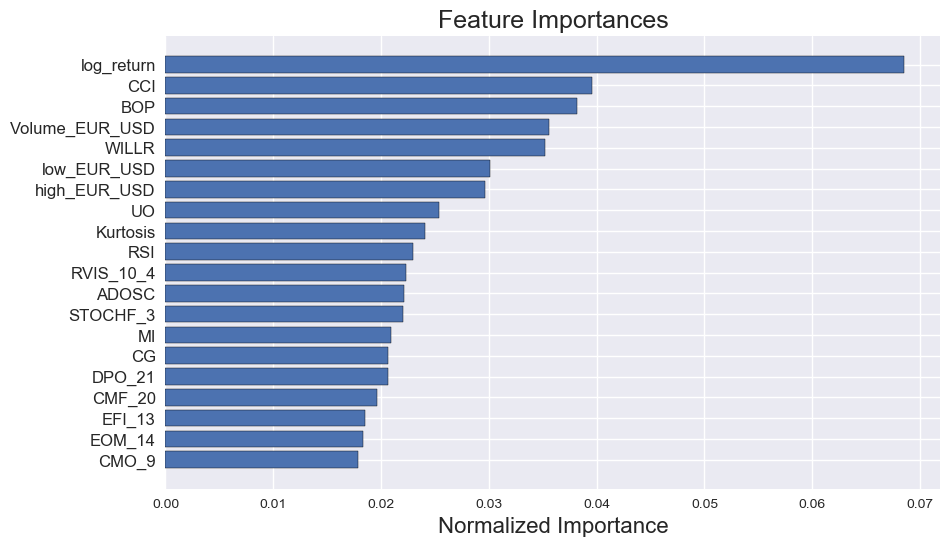

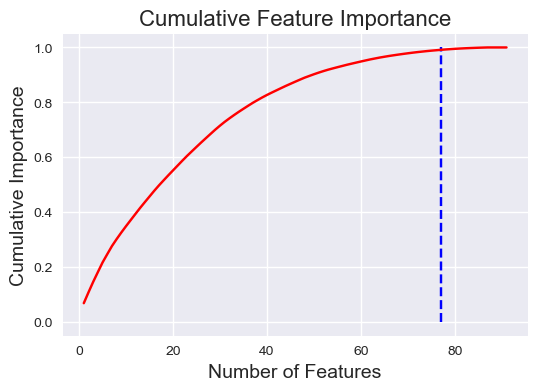

77 features required for 0.99 of cumulative importance


In [92]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)

All of the feature importances are accessible in the `feature_importances` attribute of the `FeatureSelector`

In [93]:
fs.feature_importances.head(10)

feature  importance  normalized_importance  cumulative_importance
0      log_return      2054.0               0.068467               0.068467
1             CCI      1186.0               0.039533               0.108000
2             BOP      1146.0               0.038200               0.146200
3  Volume_EUR_USD      1068.0               0.035600               0.181800
4           WILLR      1056.0               0.035200               0.217000
5     low_EUR_USD       904.0               0.030133               0.247133
6    high_EUR_USD       888.0               0.029600               0.276733
7              UO       762.0               0.025400               0.302133
8        Kurtosis       722.0               0.024067               0.326200
9             RSI       690.0               0.023000               0.349200

# 3. Low Importance Features

This method builds off the feature importances from the gradient boosting machine (`identify_zero_importance` must be run first) by finding the lowest importance features not needed to reach a specified cumulative total feature importance. For example, if we pass in 0.99, this will find the lowest important features that are not needed to reach 99% of the total feature importance. 

When using this method, we must have already run `identify_zero_importance` and need to pass in a `cumulative_importance` that accounts for that fraction of total feature importance.

__Note of caution__: this method builds on the gradient boosting model features importances and again is non-deterministic. I advise running these two methods several times with varying parameters and testing each resulting set of features rather than picking one number and sticking to it.

In [94]:
fs.identify_low_importance(cumulative_importance = 0.98)

70 features required for cumulative importance of 0.98 after one hot encoding.
21 features do not contribute to cumulative importance of 0.98.



The low importance features to remove are those that do not contribute to the specified cumulative importance. These are also available in the `ops` dictionary. 

In [95]:
low_importance_features = fs.ops['low_importance']
low_importance_features[:]

['OBV_EMA_2',
 'SMA_25',
 'AMAT_LR_2',
 'KCL_20',
 'EMA_50',
 'T3',
 'VWMA',
 'DEMA_9',
 'linreg_tsf',
 'ACCE_L',
 'SMA_10',
 'KCU_20',
 'EMA_12',
 'AOBV_SR_2',
 'AMAT_SR_2',
 'KCB_20',
 'EMA_26',
 'linreg_slope',
 'BBM_20',
 'APO',
 'linreg_deg']

# Removing Features

Once we have identified the features to remove, we have a number of ways to drop the features. We can access any of the feature lists in the `removal_ops` dictionary and remove the columns manually. We also can use the `remove` method, passing in the methods that identified the features we want to remove, or simply reload the data and drop the columns using pandas methods 

In [96]:
data = pd.read_csv('dataset/ta_EUR_USD.csv', index_col=['time_EUR_USD']) 
data = data.drop(low_importance_features[:], axis=1)
data

close_EUR_USD  open_EUR_USD  high_EUR_USD  \
time_EUR_USD                                                                
2010-01-03T14:00:00.000000000Z        1.43172       1.43120       1.43172   
2010-01-03T18:00:00.000000000Z        1.43036       1.43172       1.43425   
2010-01-03T22:00:00.000000000Z        1.42714       1.43030       1.43358   
2010-01-04T02:00:00.000000000Z        1.43012       1.42712       1.43089   
2010-01-04T06:00:00.000000000Z        1.43948       1.43010       1.43964   
...                                       ...           ...           ...   
2019-12-31T02:00:00.000000000Z        1.12070       1.12126       1.12148   
2019-12-31T06:00:00.000000000Z        1.12136       1.12070       1.12176   
2019-12-31T10:00:00.000000000Z        1.12380       1.12138       1.12391   
2019-12-31T14:00:00.000000000Z        1.12290       1.12381       1.12393   
2019-12-31T18:00:00.000000000Z        1.12121       1.12289       1.12290   

                                low_EUR_USD  Volume_EUR_USD  Histogram  \
time_EUR_USD                                                             
2010-01-03T14:00:00.000000000Z      1.43120               3        NaN   
2010-01-03T18:00:00.000000000Z      1.42926            1024        NaN   
2010-01-03T22:00:00.000000000Z      1.42576            5994        NaN   
2010-01-04T02:00:00.000000000Z      1.42708            2836        NaN   
2010-01-04T06:00:00.000000000Z      1.42694            9020        NaN   
...                                     ...             ...        ...   
2019-12-31T02:00:00.000000000Z      1.11988            2514   0.002867   
2019-12-31T06:00:00.000000000Z      1.12031            7702   0.002881   
2019-12-31T10:00:00.000000000Z      1.12086           12080   0.003055   
2019-12-31T14:00:00.000000000Z      1.12162           20217   0.003084   
2019-12-31T18:00:00.000000000Z      1.12102            3345   0.002937   

                                    MACD    Signal    SMA_50   SMA_100  ...  \
time_EUR_USD                                                            ...   
2010-01-03T14:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-03T18:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-03T22:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-04T02:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
2010-01-04T06:00:00.000000000Z       NaN       NaN       NaN       NaN  ...   
...                                  ...       ...       ...       ...  ...   
2019-12-31T02:00:00.000000000Z  0.000553  0.002314  1.112375  1.111772  ...   
2019-12-31T06:00:00.000000000Z  0.000454  0.002427  1.112520  1.111881  ...   
2019-12-31T10:00:00.000000000Z  0.000502  0.002553  1.112726  1.112015  ...   
2019-12-31T14:00:00.000000000Z  0.000425  0.002659  1.112918  1.112138  ...   
2019-12-31T18:00:00.000000000Z  0.000222  0.002715  1.113107  1.112243  ...   

                                   stdev   STOCHF_3   STOCH_14    STOCH_3  \
time_EUR_USD                                                                
2010-01-03T14:00:00.000000000Z       NaN        NaN        NaN        NaN   
2010-01-03T18:00:00.000000000Z       NaN        NaN        NaN        NaN   
2010-01-03T22:00:00.000000000Z       NaN        NaN        NaN        NaN   
2010-01-04T02:00:00.000000000Z       NaN        NaN        NaN        NaN   
2010-01-04T06:00:00.000000000Z       NaN        NaN        NaN        NaN   
...                                  ...        ...        ...        ...   
2019-12-31T02:00:00.000000000Z  0.004861  88.596081  93.070734  92.119745   
2019-12-31T06:00:00.000000000Z  0.004803  92.016405  92.700719  92.471151   
2019-12-31T10:00:00.000000000Z  0.004813  93.871172  92.837448  92.869633   
2019-12-31T14:00:00.000000000Z  0.004656  94.219915  92.435479  92.657882   
2019-12-31T18:00:00.000000000Z  0.004367  85.969503  90.676682  91.983203   

                                    T

## Now we can run our model again but this time without these features 

Repeat the same steps from building the model 

In [97]:
data.dropna(inplace=True)

In [98]:
scale_target = MinMaxScaler()

target = data['close_EUR_USD']
target = scale_target.fit_transform(target.values.reshape(-1, 1))

scale_data = MinMaxScaler(feature_range=(0, 1))
data = scale_data.fit_transform(data.values)
data

array([[7.09647638e-01, 7.11623000e-01, 7.07398043e-01, ...,
        5.60217730e-01, 1.00000000e+00, 4.03647416e-01],
       [7.15055063e-01, 7.09666784e-01, 7.11927009e-01, ...,
        5.84385560e-01, 9.99447102e-01, 5.56574924e-01],
       [7.19803047e-01, 7.15073853e-01, 7.17291415e-01, ...,
        6.37003450e-01, 9.98916170e-01, 7.24581725e-01],
       ...,
       [1.90842547e-01, 1.85510814e-01, 1.86325162e-01, ...,
        8.43157726e-01, 4.49437492e-05, 9.90946502e-01],
       [1.88864221e-01, 1.90851943e-01, 1.86369133e-01, ...,
        8.18053975e-01, 6.45343900e-06, 8.99707887e-01],
       [1.85149364e-01, 1.88829787e-01, 1.84104650e-01, ...,
        7.10138586e-01, 0.00000000e+00, 6.88430699e-01]])

In [99]:
past_history = 120
future_target = 2
STEP = 1

x_train, y_train = multivariate_data(data, data[:, 1], 0,
                                                   training_data, past_history,
                                                   future_target, STEP)
x_test, y_test = multivariate_data(data, data[:, 1],
                                               training_data, None, past_history,
                                               future_target, STEP)

In [100]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [101]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=x_train.shape[-2:]))

multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu'))

multi_step_model.add(tf.keras.layers.Dense(2))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0) ,loss='mae', metrics=['accuracy'])

earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.001,
  patience=3)

In [102]:
EPOCHS = 10
EVALUATION = 2000
multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS, validation_data=val_data,
                                         steps_per_epoch=EVALUATION, validation_steps=50, 
                                         callbacks=[earlystop_callback])

Train for 2000 steps, validate for 50 steps
Epoch 1/10
2000/2000 [==============================] - 334s 167ms/step - loss: 0.0293 - accuracy: 0.4979 - val_loss: 0.0139 - val_accuracy: 0.4942
Epoch 2/10
2000/2000 [==============================] - 326s 163ms/step - loss: 0.0168 - accuracy: 0.5008 - val_loss: 0.0142 - val_accuracy: 0.5032
Epoch 3/10
2000/2000 [==============================] - 329s 165ms/step - loss: 0.0137 - accuracy: 0.5035 - val_loss: 0.0118 - val_accuracy: 0.4967
Epoch 4/10
2000/2000 [==============================] - 321s 160ms/step - loss: 0.0119 - accuracy: 0.5025 - val_loss: 0.0127 - val_accuracy: 0.4868
Epoch 5/10
2000/2000 [==============================] - 315s 157ms/step - loss: 0.0108 - accuracy: 0.5009 - val_loss: 0.0129 - val_accuracy: 0.4930
Epoch 6/10
2000/2000 [==============================] - 316s 158ms/step - loss: 0.0100 - accuracy: 0.5038 - val_loss: 0.0128 - val_accuracy: 0.5007


In [103]:
multi_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 32)           13312     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 16,482
Trainable params: 16,482
Non-trainable params: 0
_________________________________________________________________


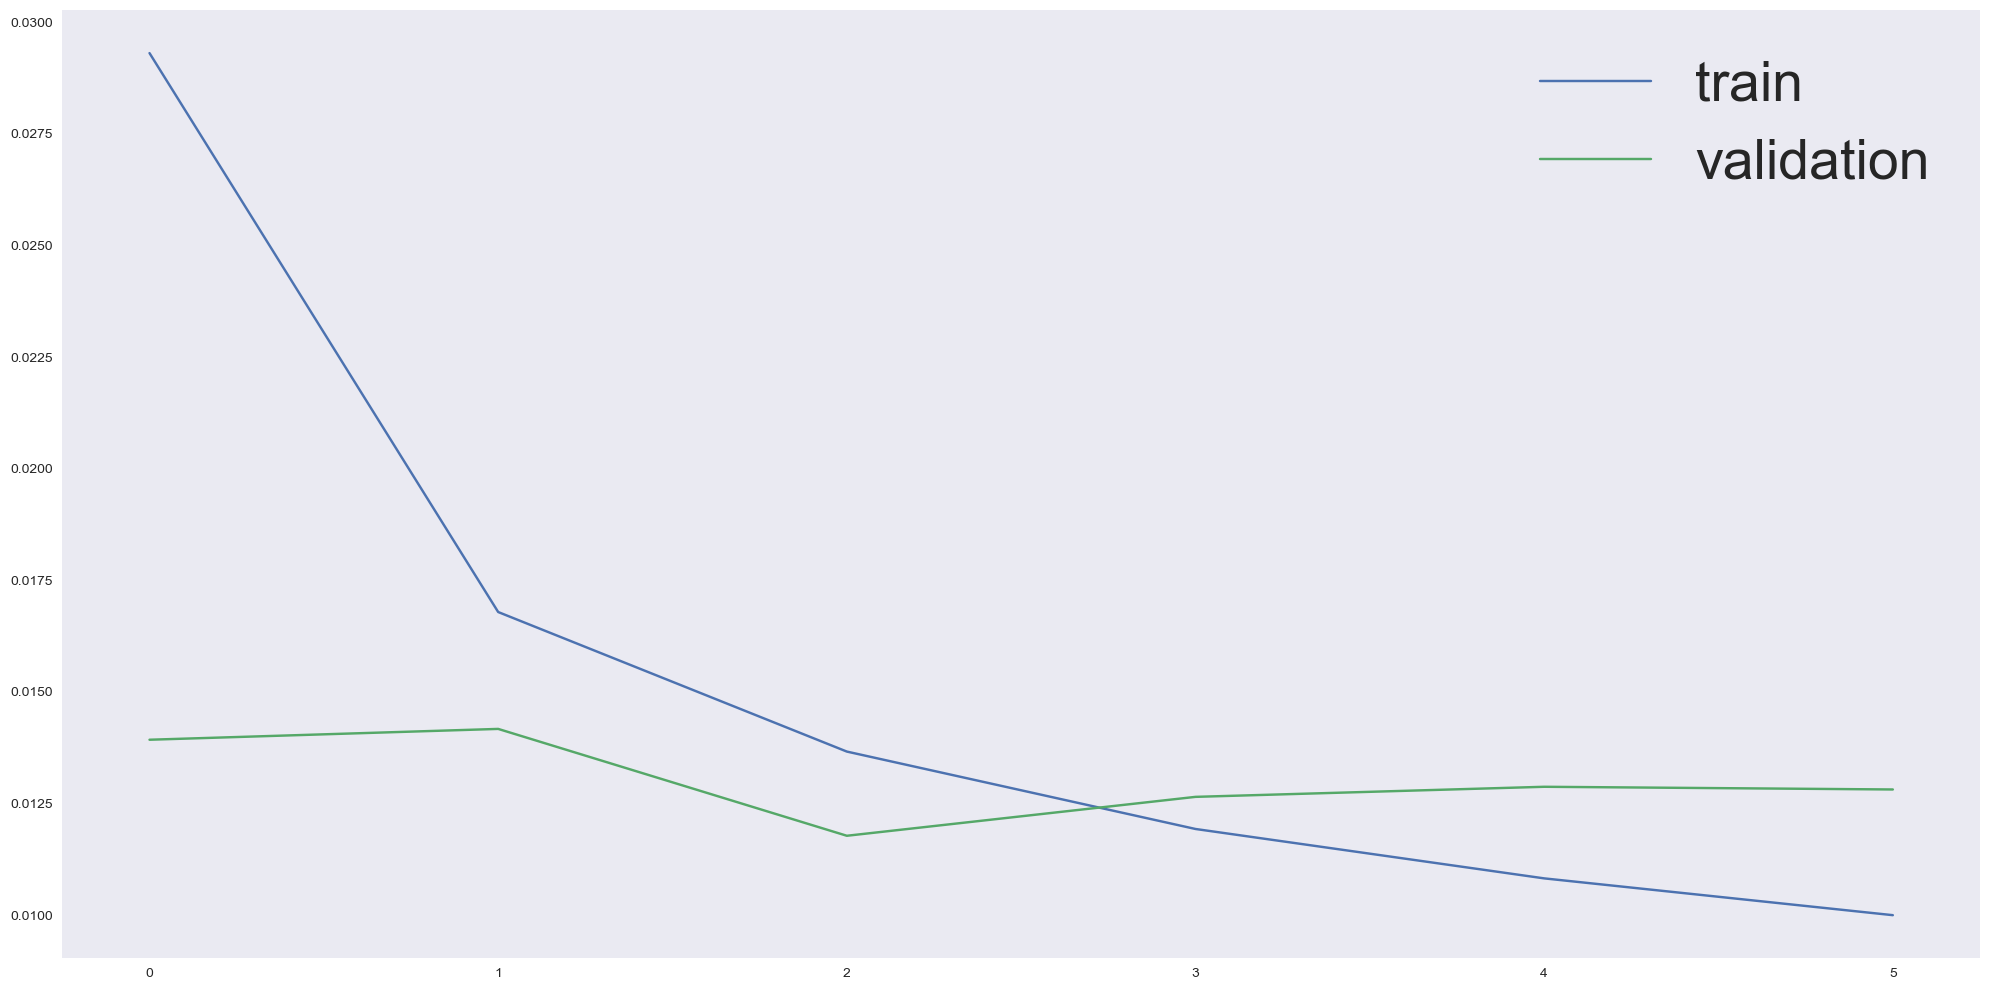

In [104]:
plt.figure(figsize=(20,10))
plt.plot(multi_step_history.history['loss'][-9:], label='train')
plt.plot(multi_step_history.history['val_loss'][-9:], label='validation')
plt.legend(fontsize=40)
plt.grid()
plt.tight_layout()
plt.show()

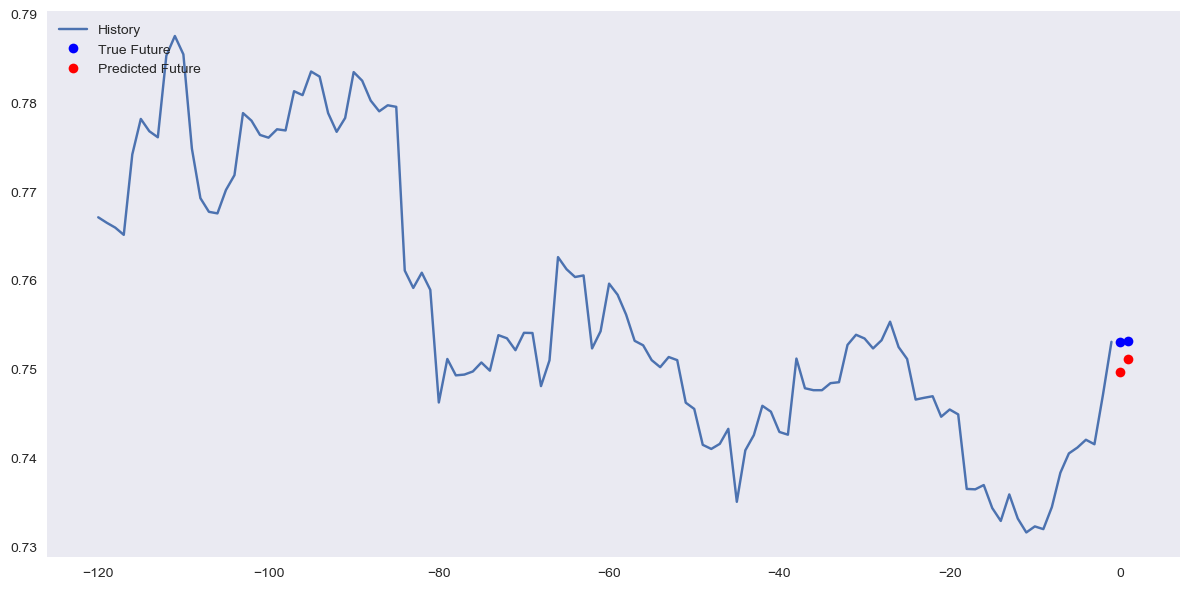

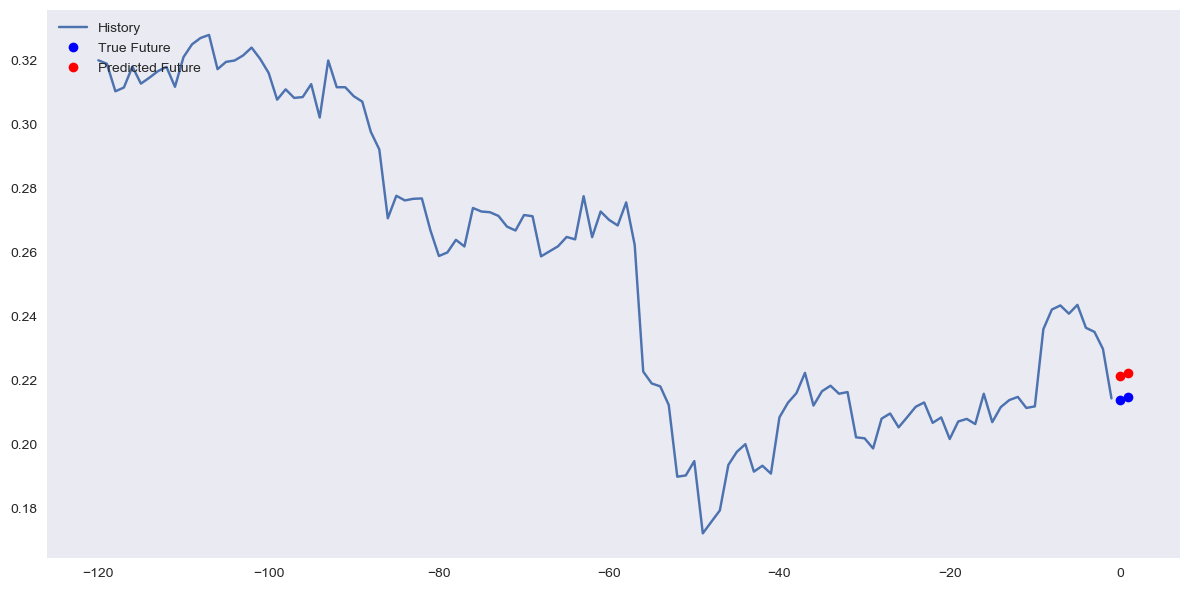

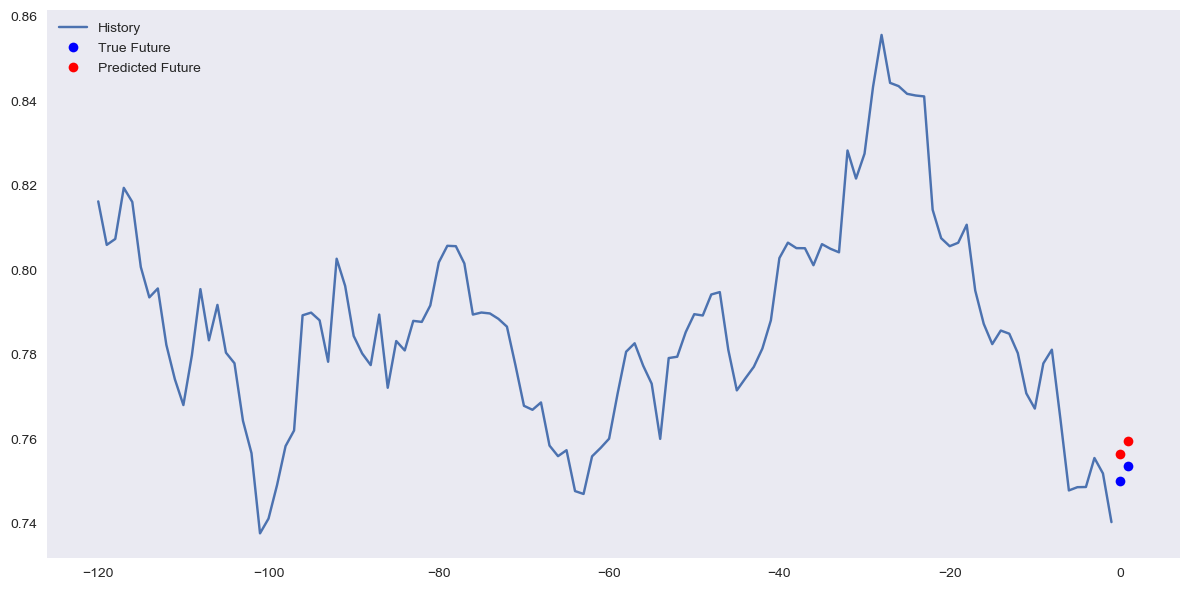

In [105]:
for x, y in train_data.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])